In [1]:
import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/netmap')

from src.utils.netmap_config import NetmapConfig

from src.model.negbinautoencoder import *
import scanpy as sc

from sklearn.model_selection import train_test_split
import time
from captum.attr import GradientShap
from src.model.inferrence_simple import *
from src.utils.data_utils import attribution_to_anndata
import src.downstream.downstream as d
import src.model.pipeline as p
import src.downstream.downstreammain as d

In [2]:
adata_full = sc.read_h5ad('/data_nfs/um72icix/tox_ko_wt.h5ad')

In [14]:
adata_full.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100328568 stored elements and shape (61428, 30912)>

In [67]:
adata = adata_full.copy()

In [68]:
adata_full.obs.cluster = pd.Categorical(adata_full.obs.cluster)

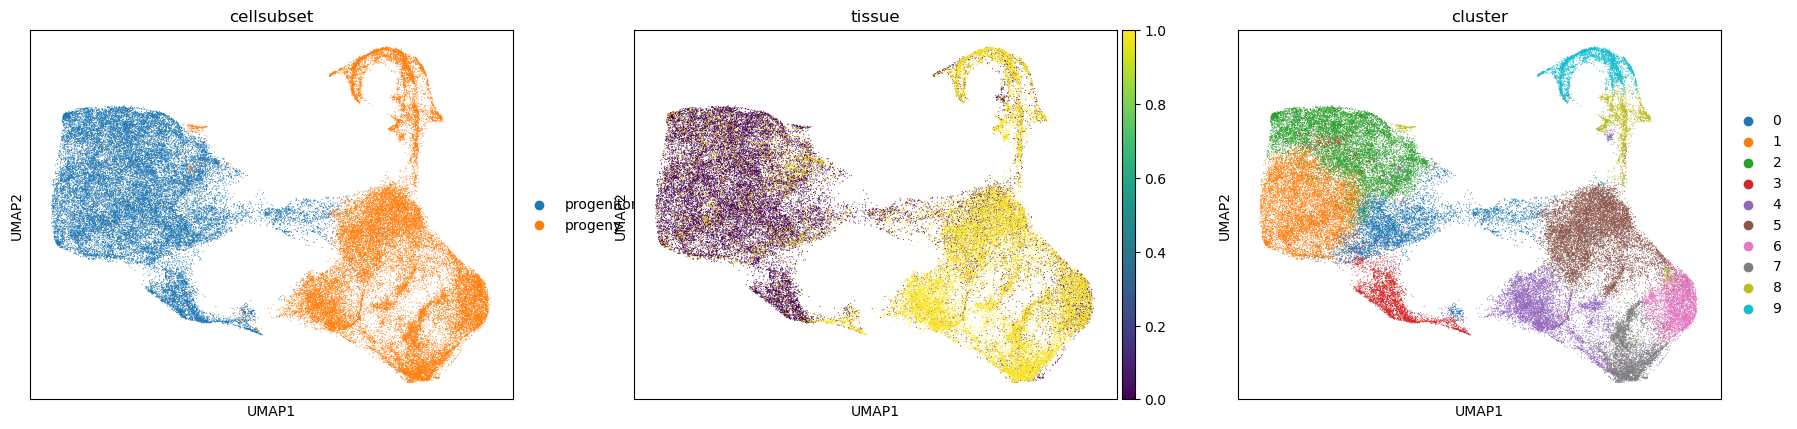

In [69]:
sc.pl.umap(adata_full, color = ['cellsubset', 'tissue', 'cluster'])

In [65]:
adata = adata[adata.obs.Sample_Name.isin(['ko_spleen_1', 'ko_spleen_2', 'ko_spleen_3'])]

In [70]:
adata = adata[adata.obs.cluster.isin([0,1])]

In [71]:
adata.layers['counts'] = adata.X

In [72]:
adata

AnnData object with n_obs × n_vars = 15629 × 30912
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_Tag', 'Sample_Name', 'sample', 'genotype', 'tissue', 'subject', 'time', 'cells', 'Total_VDJ_Read_Count', 'Total_VDJ_Molecule_Count', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_C_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Nucleotide_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCR_Alpha_Gamma_Read_Count', 'TCR_Alpha_Gamma_Molecule_Count', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_C_gene_Dominant', 'TCR_Beta_Delta_CDR3_Nucleotide_Dominant', 'TCR_Beta_Delta_CDR3_Translation_Dominant', 'TCR_Beta_Delta_Read_Count', 'TCR_Beta_Delta_Molecule_Count', 'TCR_Paired_Chains', 'Cell_Type_Experimental', 'infection', 'group', 'subgroup', 'percent.mito', 'percent.ribo', 'ts_tp', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.43', 'cluster', 'cellsubset', 'barcode

In [73]:
adata.var_names_make_unique()

sc.pp.normalize_total(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=2000)
sc.pp.pca(adata)


In [50]:
gene_names = np.array(adata.var.index)

In [74]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.3, flavor='igraph')
sc.tl.umap(adata)

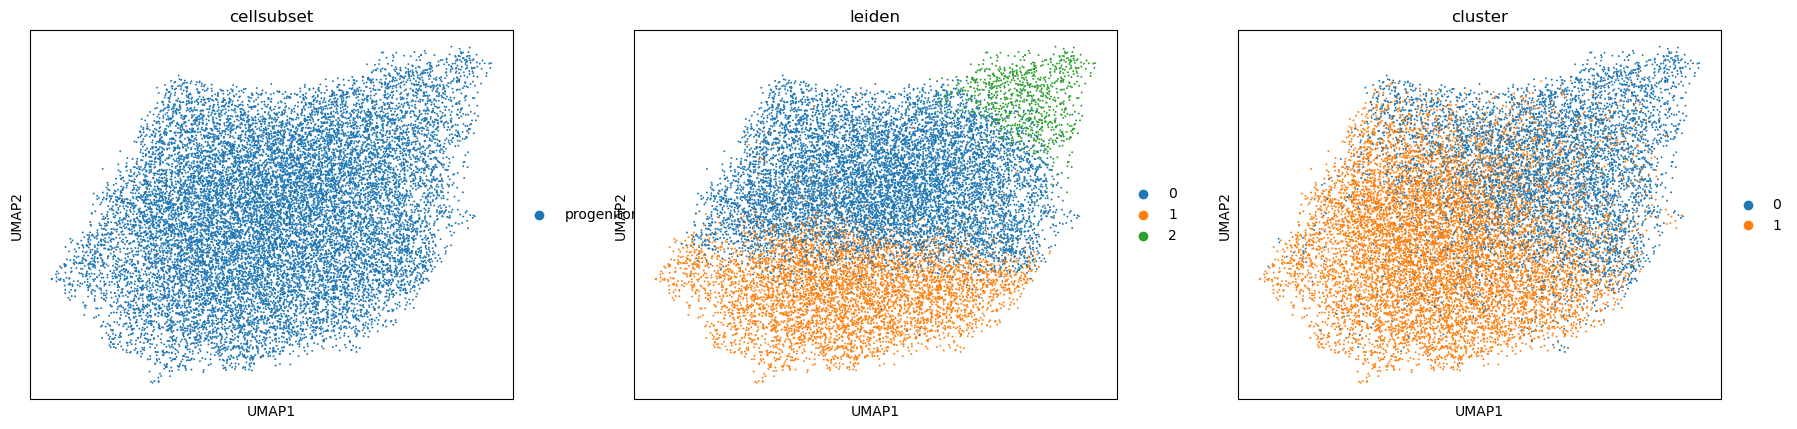

In [77]:
sc.pl.umap(adata, color = ['cellsubset', 'leiden', 'cluster'])

In [76]:
adata

AnnData object with n_obs × n_vars = 15629 × 1999
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_Tag', 'Sample_Name', 'sample', 'genotype', 'tissue', 'subject', 'time', 'cells', 'Total_VDJ_Read_Count', 'Total_VDJ_Molecule_Count', 'TCR_Alpha_Gamma_V_gene_Dominant', 'TCR_Alpha_Gamma_J_gene_Dominant', 'TCR_Alpha_Gamma_C_gene_Dominant', 'TCR_Alpha_Gamma_CDR3_Nucleotide_Dominant', 'TCR_Alpha_Gamma_CDR3_Translation_Dominant', 'TCR_Alpha_Gamma_Read_Count', 'TCR_Alpha_Gamma_Molecule_Count', 'TCR_Beta_Delta_V_gene_Dominant', 'TCR_Beta_Delta_D_gene_Dominant', 'TCR_Beta_Delta_J_gene_Dominant', 'TCR_Beta_Delta_C_gene_Dominant', 'TCR_Beta_Delta_CDR3_Nucleotide_Dominant', 'TCR_Beta_Delta_CDR3_Translation_Dominant', 'TCR_Beta_Delta_Read_Count', 'TCR_Beta_Delta_Molecule_Count', 'TCR_Paired_Chains', 'Cell_Type_Experimental', 'infection', 'group', 'subgroup', 'percent.mito', 'percent.ribo', 'ts_tp', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.43', 'cluster', 'cellsubset', 'barcode'

In [47]:
def create_model_zoo(data_tensor, n_models = 4):
    model_zoo = []
    for _ in range(n_models):


        start = time.monotonic()
        data_train2, data_test2 = train_test_split(data_tensor,test_size=0.95, shuffle=True)

        trained_model2 = NegativeBinomialAutoencoder(input_dim=data_tensor.shape[1], latent_dim=10, dropout_rate = 0.25)
        trained_model2 = trained_model2.cuda()

        optimizer2 = torch.optim.Adam(trained_model2.parameters(), lr=1e-4)

        trained_model2 = train_autoencoder(
                trained_model2,
                data_train2.cuda(),
                optimizer2,
                num_epochs=300

            )
        model_zoo.append(trained_model2)
    return model_zoo


In [48]:
data_tensor = torch.tensor(adata.layers['counts'].todense(), dtype=torch.float32)

model_zoo = create_model_zoo(data_tensor, n_models=2)


Epoch 1/300, Loss: 0.6262
Epoch 11/300, Loss: 0.4962
Epoch 21/300, Loss: 0.2980
Epoch 31/300, Loss: 0.2643
Epoch 41/300, Loss: 0.2498
Epoch 51/300, Loss: 0.2472
Epoch 61/300, Loss: 0.2403
Epoch 71/300, Loss: 0.2366
Epoch 81/300, Loss: 0.2318
Epoch 91/300, Loss: 0.2306
Epoch 101/300, Loss: 0.2277
Epoch 111/300, Loss: 0.2252
Epoch 121/300, Loss: 0.2243
Epoch 131/300, Loss: 0.2213
Epoch 141/300, Loss: 0.2197
Epoch 151/300, Loss: 0.2174
Epoch 161/300, Loss: 0.2146
Epoch 171/300, Loss: 0.2135
Epoch 181/300, Loss: 0.2128
Epoch 191/300, Loss: 0.2118
Epoch 201/300, Loss: 0.2093
Epoch 211/300, Loss: 0.2088
Epoch 221/300, Loss: 0.2076
Epoch 231/300, Loss: 0.2079
Epoch 241/300, Loss: 0.2061
Epoch 251/300, Loss: 0.2055
Epoch 261/300, Loss: 0.2048
Epoch 271/300, Loss: 0.2050
Epoch 281/300, Loss: 0.2036
Epoch 291/300, Loss: 0.2035
Epoch 1/300, Loss: 0.6079
Epoch 11/300, Loss: 0.4471
Epoch 21/300, Loss: 0.2858
Epoch 31/300, Loss: 0.2591
Epoch 41/300, Loss: 0.2498
Epoch 51/300, Loss: 0.2445
Epoch 61/3

In [49]:
from sklearn.cluster import HDBSCAN

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import HDBSCAN


def set_latent_true(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = True
    return model_zoo


def set_all_false(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo


def pair_cooccurence(u, v):
  u_arr = np.array(u)
  v_arr = np.array(v)
  term1 = np.sum(u_arr-v_arr!=0)
  return term1 / len(u_arr)

In [50]:
def compute_consensus_clustering(model_zoo, data_tensor):
    model_zoo = set_latent_true(model_zoo)
    clusterings = {}
    for m in range(len(model_zoo)):
        print(m)
        latent = model_zoo[m](data_tensor.cuda())
        latent = sc.AnnData(latent.detach().cpu().numpy())
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        sc.tl.leiden(latent, resolution=0.1)
        clusterings[f'leiden_{m}'] = latent.obs[f'leiden']
    model_zoo = set_all_false(model_zoo)

    clusterings = pd.DataFrame(clusterings)

    latent.obs = pd.concat([latent.obs, clusterings], axis=1)
    clustering = clusterings.values.astype(int) 

    pairwise_distances_flat = pdist(clustering, metric=pair_cooccurence)
    pairwise_distances_matrix = squareform(pairwise_distances_flat)

    hdb = HDBSCAN(min_cluster_size=50, metric= 'precomputed')
    hdb.fit(pairwise_distances_matrix)
    latent.obs['consensus'] = hdb.labels_


    return latent

In [61]:
def compute_consensus_clustering(model_zoo, data_tensor):
    model_zoo = set_latent_true(model_zoo)
    clusterings = {}
    latent = model_zoo[1](data_tensor.cuda())
    latent = sc.AnnData(latent.detach().cpu().numpy())
    sc.pp.neighbors(latent)
    sc.tl.umap(latent)
    sc.tl.leiden(latent, resolution=0.1)


    return latent

In [62]:
latent = compute_consensus_clustering(model_zoo, data_tensor)


In [54]:
adata_full.obs

,orig.ident,nCount_RNA,nFeature_RNA,Sample_Tag,Sample_Name,sample,genotype,tissue,subject,time,...,cellsubset,barcode,CTgene,CTnt,CTaa,CTstrict,Frequency,cloneType,Proportion,propType
ko_spleen_1_d10_40,0,2015.0,1198,SampleTag04_mm,ko_spleen_1,0,0,0,0,0,...,progenitor,ko_spleen_1_d10_40,TRAV14-3*01.TRAJ15*01.TRAC_TRBV13-1*02.TRBD1*0...,GCAGCAAACCAGGGAGGCAGAGCTCTGATA_GCCAGCAGTGATTTC...,AANQGGRALI_ASSDFGGGQDTQY,TRAV14-3*01.TRAJ15*01.TRAC_GCAGCAAACCAGGGAGGCA...,1553,0,0.572007,0
ko_spleen_1_d10_9623,0,3229.0,1694,SampleTag04_mm,ko_spleen_1,0,0,0,0,0,...,progeny,ko_spleen_1_d10_9623,TRAV14-3*01.TRAJ15*01.TRAC_TRBV13-1*02.TRBD1*0...,GCAGCAAACCAGGGAGGCAGAGCTCTGATA_GCCAGCAGTGATTTC...,AANQGGRALI_ASSDFGGGQDTQY,TRAV14-3*01.TRAJ15*01.TRAC_GCAGCAAACCAGGGAGGCA...,1553,0,0.572007,0
ko_spleen_1_d10_14684,0,4878.0,2337,SampleTag04_mm,ko_spleen_1,0,0,0,0,0,...,progenitor,ko_spleen_1_d10_14684,NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC,NA_GCCAGCAGTGATTTCGGGGGAGGCCAAGACACCCAGTAC,NA_ASSDFGGGQDTQY,NA_NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC_GCC...,820,0,0.302026,0
ko_spleen_1_d10_15780,0,1827.0,1203,SampleTag04_mm,ko_spleen_1,0,0,0,0,0,...,progenitor,ko_spleen_1_d10_15780,NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC,NA_GCCAGCAGTGATTTCGGGGGAGGCCAAGACACCCAGTAC,NA_ASSDFGGGQDTQY,NA_NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC_GCC...,820,0,0.302026,0
ko_spleen_1_d10_20052,0,3143.0,1695,SampleTag04_mm,ko_spleen_1,0,0,0,0,0,...,progenitor,ko_spleen_1_d10_20052,TRAV14-3*01.TRAJ15*01.TRAC_NA,GCAGCAAACCAGGGAGGCAGAGCTCTGATA_NA,AANQGGRALI_NA,TRAV14-3*01.TRAJ15*01.TRAC_GCAGCAAACCAGGGAGGCA...,130,0,0.047882,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wt_liver_3_d20_56459263,0,1490.0,968,SampleTag09_mm,wt_liver_3,23,1,1,2,1,...,progeny,wt_liver_3_d20_56459263,TRAV14-3*01.TRAJ15*01.TRAC_TRBV13-1*02.TRBD1*0...,GCAGCAAACCAGGGAGGCAGAGCTCTGATA_GCCAGCAGTGATTTC...,AANQGGRALI_ASSDFGGGQDTQY,TRAV14-3*01.TRAJ15*01.TRAC_GCAGCAAACCAGGGAGGCA...,1128,0,0.613711,0
wt_liver_3_d20_56480934,0,1312.0,869,SampleTag09_mm,wt_liver_3,23,1,1,2,1,...,progeny,wt_liver_3_d20_56480934,TRAV14-2*02.TRAJ40*01.TRAC_TRBV13-1*02.TRBD1*0...,GCAGCAAGTGATACAGGAAACTACAAATACGTC_GCCAGCAGTGAT...,AASDTGNYKYV_ASSDFGGGQDTQY,TRAV14-2*02.TRAJ40*01.TRAC_GCAGCAAGTGATACAGGAA...,3,3,0.001632,2
wt_liver_3_d20_56575959,0,1749.0,1150,SampleTag09_mm,wt_liver_3,23,1,1,2,1,...,progeny,wt_liver_3_d20_56575959,TRAV14-3*01.TRAJ15*01.TRAC_TRBV13-1*02.TRBD1*0...,GCAGCAAACCAGGGAGGCAGAGCTCTGATA_GCCAGCAGTGATTTC...,AANQGGRALI_ASSDFGGGQDTQY,TRAV14-3*01.TRAJ15*01.TRAC_GCAGCAAACCAGGGAGGCA...,1128,0,0.613711,0
wt_liver_3_d20_56606449,0,1537.0,985,SampleTag09_mm,wt_liver_3,23,1,1,2,1,...,progeny,wt_liver_3_d20_56606449,NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC,NA_GCCAGCAGTGATTTCGGGGGAGGCCAAGACACCCAGTAC,NA_ASSDFGGGQDTQY,NA_NA_TRBV13-1*02.TRBD1*01.TRBJ2-5*01.TRBC_GCC...,485,0,0.263874,0


In [63]:
latent.obs['cellsubset'] = list(adata.obs['cellsubset'])
latent.obs['Sample_Name'] = list(adata.obs['Sample_Name'])
latent.obs['time'] = list(adata.obs['time'])
latent.obs['genotype'] = list(adata.obs['genotype'])
latent.obs['tissue'] = list(adata.obs['tissue'])

In [64]:
latent.obs

,leiden,cellsubset,Sample_Name,time,genotype,tissue
0,0,progeny,ko_spleen_1,0,0,0
1,0,progeny,ko_spleen_1,0,0,0
2,0,progeny,ko_spleen_1,0,0,0
3,0,progeny,ko_spleen_1,0,0,0
4,0,progeny,ko_spleen_1,0,0,0
...,...,...,...,...,...,...
3539,0,progeny,ko_spleen_3,1,0,0
3540,1,progenitor,ko_spleen_3,1,0,0
3541,0,progeny,ko_spleen_3,1,0,0
3542,0,progeny,ko_spleen_3,1,0,0


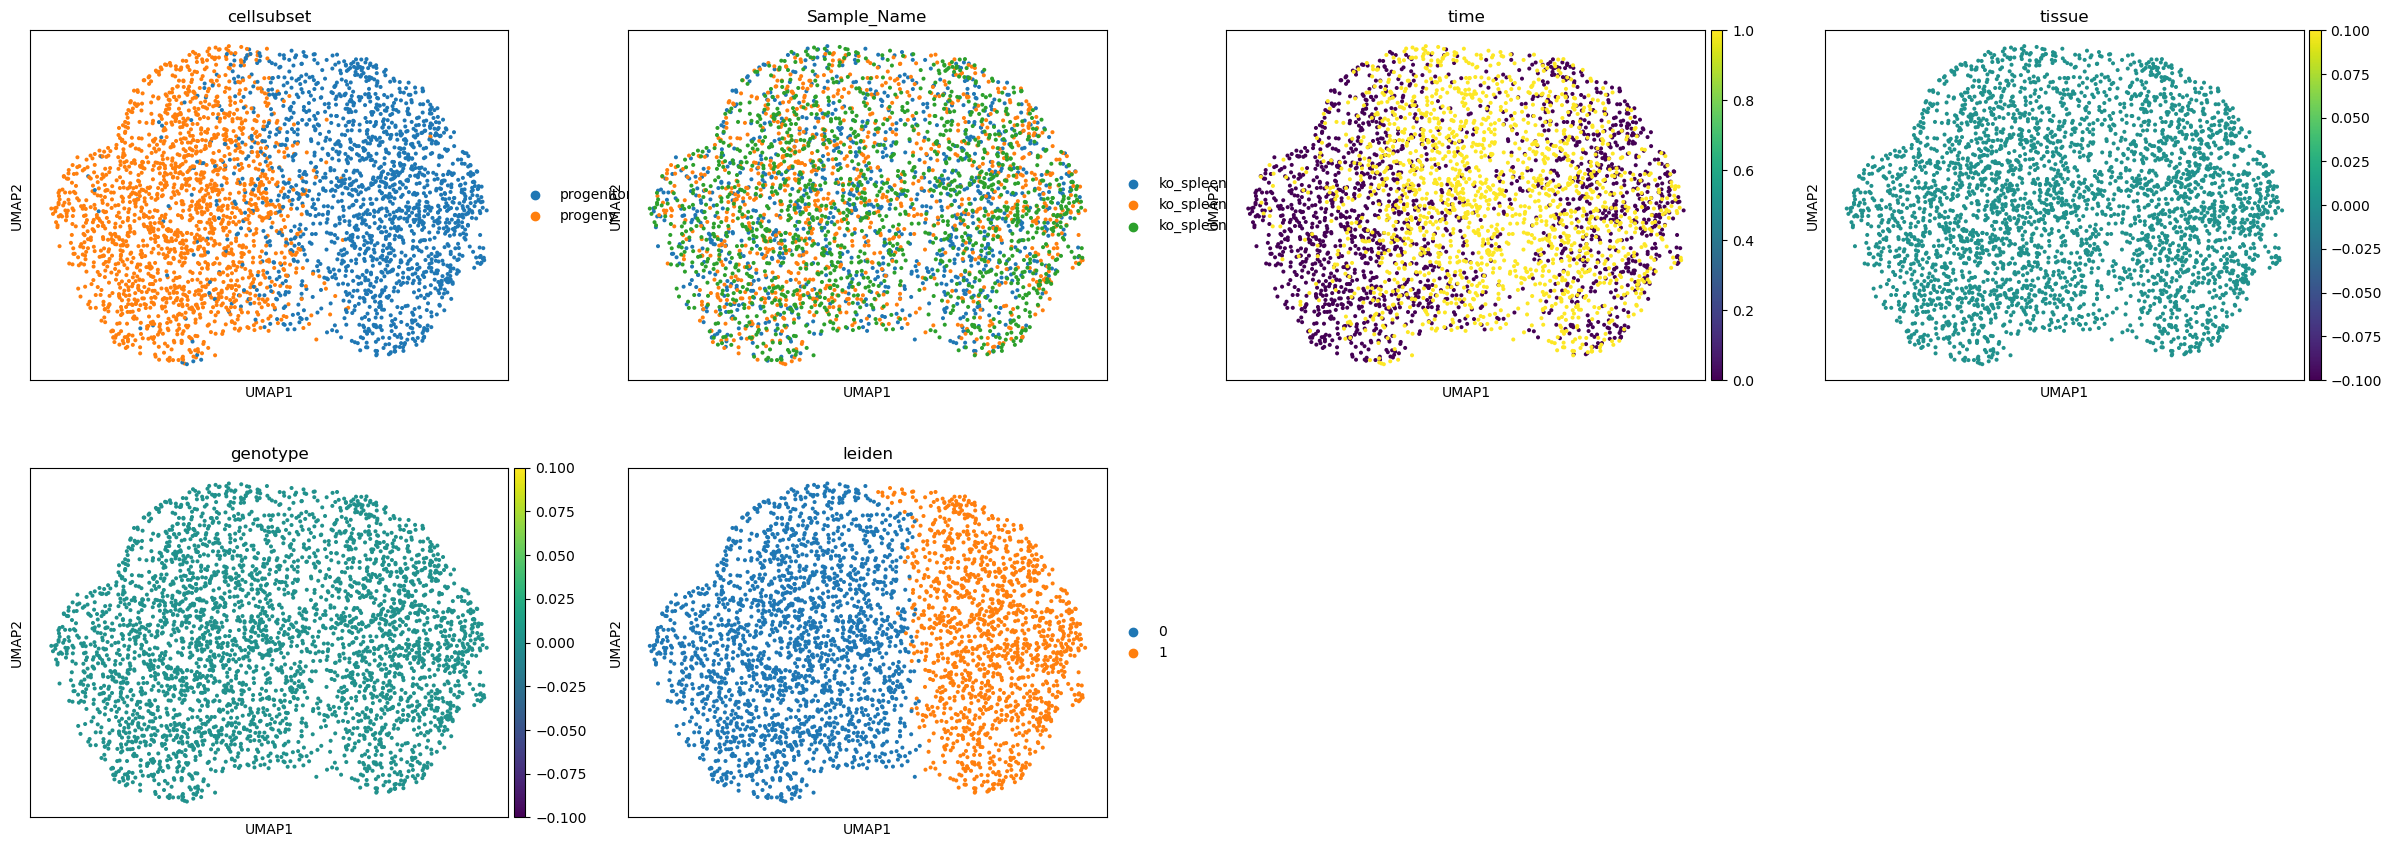

In [65]:
sc.pl.umap(latent, color = ['cellsubset', 'Sample_Name', 'time', 'tissue', 'genotype', 'leiden'])

In [ ]:
def generate_background_data(model_zoo, data_tensor, latent, cluster_var = 'consensus'):
    backgrounds = {}
    for i in latent.obs[cluster_var].unique():
        if i!=-1:
            backgrounds[i] = []

    for m in range(len(model_zoo)):
        # Get average params over all 
        mean_theta = get_thetas(model_zoo[m], data_tensor)
        mean_mu = get_mus(model_zoo[m], data_tensor)
        samples_mean = sample_from_vectors(mean_mu, mean_theta, size=200).T


        mean_mus = get_mus_grouping(model_zoo[m], data_tensor, latent.obs[cluster_var])
        mean_thetas = get_thetas_grouping(model_zoo[m], data_tensor, latent.obs[cluster_var])

        for i in backgrounds.keys():
            backgrounds[i].append(sample_from_vectors(mean_mus[i], mean_thetas[i], size=200).T)

    for b in backgrounds.keys():
        backgrounds[b] = np.concatenate(backgrounds[b])
        backgrounds[b] = torch.tensor(backgrounds[b]).cuda()

    return backgrounds



def compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, n_top = 250, cluster_var = 'consensus'):
    myexplainers = [GradientShap(mo) for mo in model_zoo]
    attributions = []
    for b in backgrounds.keys():
        aggregated_attribution, nlc = inference_complete(myexplainers, data_tensor[latent.obs[cluster_var] == b].cuda(), gene_names, backgrounds[b], xai_type='shap-like', num_iterations=5,n_top_genes=n_top )

        cou = pd.DataFrame(nlc)
        cou['target'] = list(np.repeat(adata.var.index, n_top))
        cou.columns = ['source', 'target']

        ad = attribution_to_anndata(aggregated_attribution, varnames=cou, obs=latent.obs[latent.obs[cluster_var] == b])
        ad.var = cou
        attributions.append(ad)
    return attributions


In [67]:
backgrounds = p.generate_background_data(model_zoo, data_tensor, latent, cluster_var='leiden')



In [68]:
attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, cluster_var='leiden')

  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [05:51<00:00,  5.68it/s]


In [70]:
def concatenate_cluster_anndatas(attributions):
    for a in attributions:
        a.var_names = [f'{z[0]}_{z[1]}' for z in zip(a.var['source'], a.var['target'])]
        a.var_names = [f'{z[0]}_{z[1]}' for z in zip(a.var['source'], a.var['target'])]
    aa = sc.concat(attributions, join = 'outer')
    return aa

In [86]:
def downstream_recipe(adata, min_perc: float, n_clusters: int):

    """
    Performs a downstream analysis on an AnnData object, including filtering, PCA, clustering, and UMAP.
    
    Parameters:
    -----------
    adata : AnnData
        The annotated data matrix.
    min_perc : float
        Minimum percentage of cells an edge must be expressed in to be retained.
    n_clusters : int
        Desired number of clusters.
    config : dict, optional
        Dictionary containing 'n_neighbors', 'leiden_resolution', 'n_components', 'knn_neighbors'. Defaults used if not provided.
    
    Returns:
    --------
    AnnData
        Updated AnnData object with PCA, clustering, and UMAP embeddings.
    """

    default_config = {'n_neighbors': 30, 'n_components': 30, 'knn_neighbors': 30}
    config = default_config

    n_genes_before = adata.n_vars
    sc.pp.filter_genes(adata, min_cells=int(adata.n_obs * (min_perc / 100)))
    n_genes_after = adata.n_vars
    print(f"Removed {n_genes_before - n_genes_after} edges (kept {n_genes_after} edges).")

    sc.tl.pca(adata, svd_solver='randomized', zero_center=False)

    sc.pp.neighbors(adata, n_neighbors=config['knn_neighbors'])

    cluster_found = False
    for res in np.linspace(0.05, 1.5, 30):
        sc.tl.leiden(adata, resolution=res)
        n_unique = len(np.unique(adata.obs['leiden']))
        if n_unique == n_clusters:
            cluster_found = True
            break

    if not cluster_found:
        raise ValueError(f"Could not find exactly {n_clusters} clusters. Last resolution produced {n_unique} clusters.")

    sc.tl.umap(adata, n_components=config['n_components'])

    return adata

In [78]:
aa = concatenate_cluster_anndatas(attributions)
aa

AnnData object with n_obs × n_vars = 3544 × 649678
    obs: 'leiden', 'cellsubset', 'Sample_Name', 'time', 'genotype', 'tissue'

ModuleNotFoundError: No module named 'src'

In [81]:
aa.var["source"] = aa.var.index.str.split("_").str[0]
aa.var["target"] = aa.var.index.str.split("_").str[1]
aa.var.head(4)

,source,target
1110059E24Rik_Gm16152,1110059E24Rik,Gm16152
4930444A19Rik_1110059E24Rik,4930444A19Rik,1110059E24Rik
4930444A19Rik_1700028E10Rik,4930444A19Rik,1700028E10Rik
4930444A19Rik_1700034H15Rik,4930444A19Rik,1700034H15Rik


In [82]:
# Replace NaN values with 0 if needed

if isinstance(aa.X, np.ndarray):
    aa.X = np.nan_to_num(aa.X)
else:
    aa.X.data[np.isnan(aa.X.data)] = 0

In [87]:
aa = downstream_recipe(aa, min_perc=10, n_clusters=2)
aa

Removed 313 edges (kept 649365 edges).


AnnData object with n_obs × n_vars = 3544 × 649365
    obs: 'leiden', 'cellsubset', 'Sample_Name', 'time', 'genotype', 'tissue'
    var: 'source', 'target', 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [93]:
aa.write_h5ad('/data_nfs/og86asub/netmap/dietmar/tox_test.h5ad')

In [2]:
aa = sc.read_h5ad('/data_nfs/og86asub/netmap/dietmar/tox_test.h5ad')

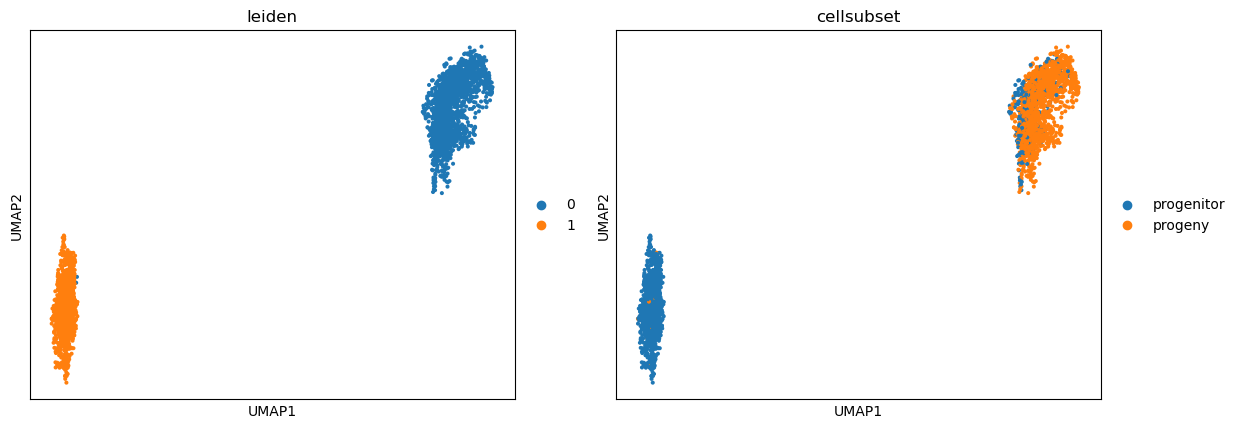

In [3]:
sc.pl.umap(aa, color = ["leiden",'cellsubset'], wspace=0.1)

In [4]:
aa = d.filter_low_count_edges(aa, min_mean_count=0.005)
aa

Filtered out 592384 genes (kept 56981).


View of AnnData object with n_obs × n_vars = 3544 × 56981
    obs: 'leiden', 'cellsubset', 'Sample_Name', 'time', 'genotype', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellsubset_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
aa[:,aa.var['source'] == 'Tox'].var.sort_values('total_counts')

,source,target,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Tox_Zfp438,Tox,Zfp438,3543,3543,0.005017,0.005005,0.028217,17.780512,2.932820
Tox_Pycr2,Tox,Pycr2,3543,3543,0.005023,0.005011,0.028217,17.802263,2.933977
Tox_Bcl2,Tox,Bcl2,3544,3544,0.005036,0.005023,0.000000,17.848072,2.936411
Tox_1700025G04Rik,Tox,1700025G04Rik,3544,3544,0.005052,0.005039,0.000000,17.902687,2.939304
Tox_St3gal4,Tox,St3gal4,3544,3544,0.005054,0.005041,0.000000,17.912071,2.939801
...,...,...,...,...,...,...,...,...,...
Tox_Smc4,Tox,Smc4,3544,3544,0.020429,0.020223,0.000000,72.400703,4.295934
Tox_Zfp36l1,Tox,Zfp36l1,3544,3544,0.020437,0.020231,0.000000,72.428535,4.296313
Tox_Skap1,Tox,Skap1,3544,3544,0.021467,0.021240,0.000000,76.079079,4.344832
Tox_Rnf213,Tox,Rnf213,3544,3544,0.027042,0.026682,0.000000,95.835403,4.573013


In [42]:
aa.obs

,leiden,cellsubset,Sample_Name,time,genotype,tissue,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
0,0,progeny,ko_spleen_1,0,0,0,460323,13.039686,1256.698730,7.137039,1.007891,1.600484,2.570437,4.760939
1,0,progeny,ko_spleen_1,0,0,0,460633,13.040359,1398.750244,7.244049,1.377042,2.306079,3.733159,6.872151
2,0,progeny,ko_spleen_1,0,0,0,461669,13.042606,1403.897339,7.247720,1.406887,2.236390,3.531416,6.321791
3,0,progeny,ko_spleen_1,0,0,0,463333,13.046203,1253.388306,7.134403,1.633444,2.491107,3.681271,6.179437
4,0,progeny,ko_spleen_1,0,0,0,458956,13.036712,1221.463745,7.108624,0.607020,1.043973,1.750317,3.351306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,1,progenitor,ko_spleen_3,1,0,0,457447,13.033418,1158.971191,7.056150,0.784740,1.309984,2.160625,4.079446
3523,1,progenitor,ko_spleen_3,1,0,0,457141,13.032749,1044.996338,6.952725,0.821111,1.374372,2.264232,4.292380
3532,1,progenitor,ko_spleen_3,1,0,0,454300,13.026515,1137.103271,7.037118,0.793357,1.338646,2.221320,4.151674
3534,1,progenitor,ko_spleen_3,1,0,0,454946,13.027936,1020.221252,6.928754,0.822992,1.409535,2.349096,4.482883


In [37]:
from scipy.stats import median_abs_deviation
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [43]:
aa.obs["outlier"] = (
    is_outlier(aa, "log1p_total_counts", 5)
)
aa.obs.outlier.value_counts()

outlier
False    3449
True       95
Name: count, dtype: int64

In [44]:
aa = aa[(~aa.obs.outlier) ].copy()

In [48]:
adata.var

,features,means,dispersions,dispersions_norm
0610040J01Rik,0610040J01Rik,0.001171,0.638806,1.914608
1110046J04Rik,1110046J04Rik,0.003704,0.806904,2.528376
1110059E24Rik,1110059E24Rik,0.059898,0.460592,1.263904
1500009L16Rik,1500009L16Rik,0.060623,0.398517,1.037254
1700001L19Rik,1700001L19Rik,0.001115,1.374558,4.601021
...,...,...,...,...
Igkv6-15,Igkv6-15,0.016120,4.053375,14.382045
Igkv6-17,Igkv6-17,0.011356,3.648836,12.904974
Semp2l2b,Semp2l2b,0.000451,0.469810,1.297564
Tmem190,Tmem190,0.000526,0.622723,1.855887


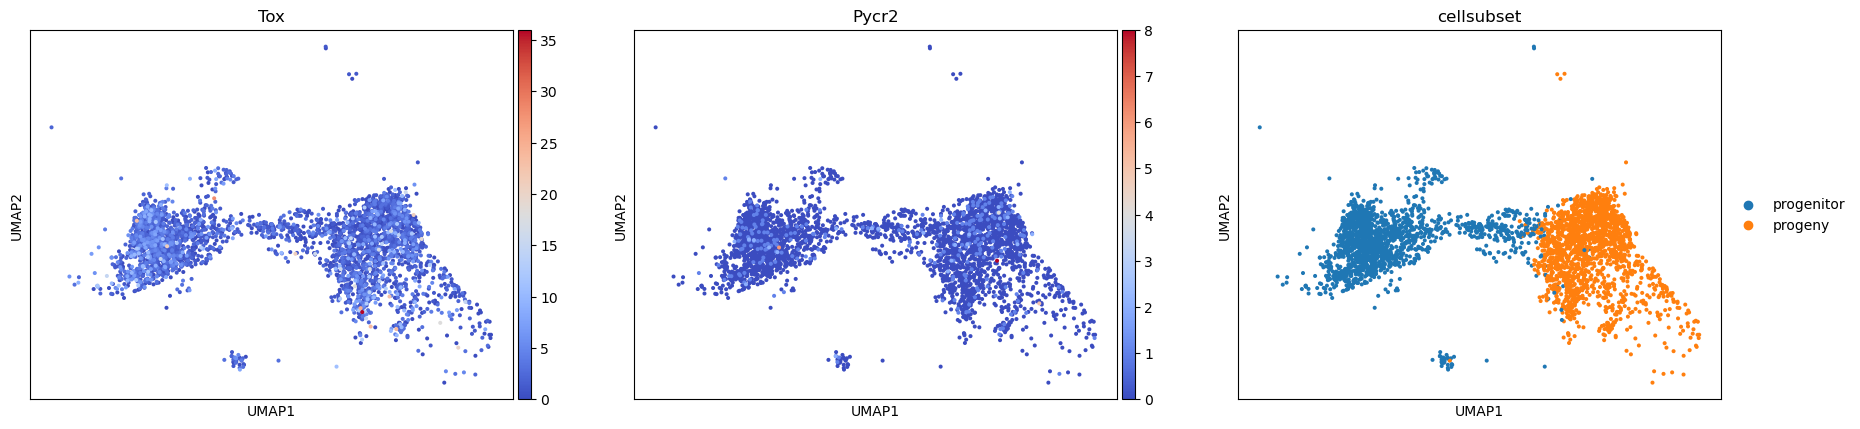

In [57]:
sc.pl.umap(adata, color = ['Tox', 'Pycr2','cellsubset'], layer = 'counts', cmap="coolwarm")

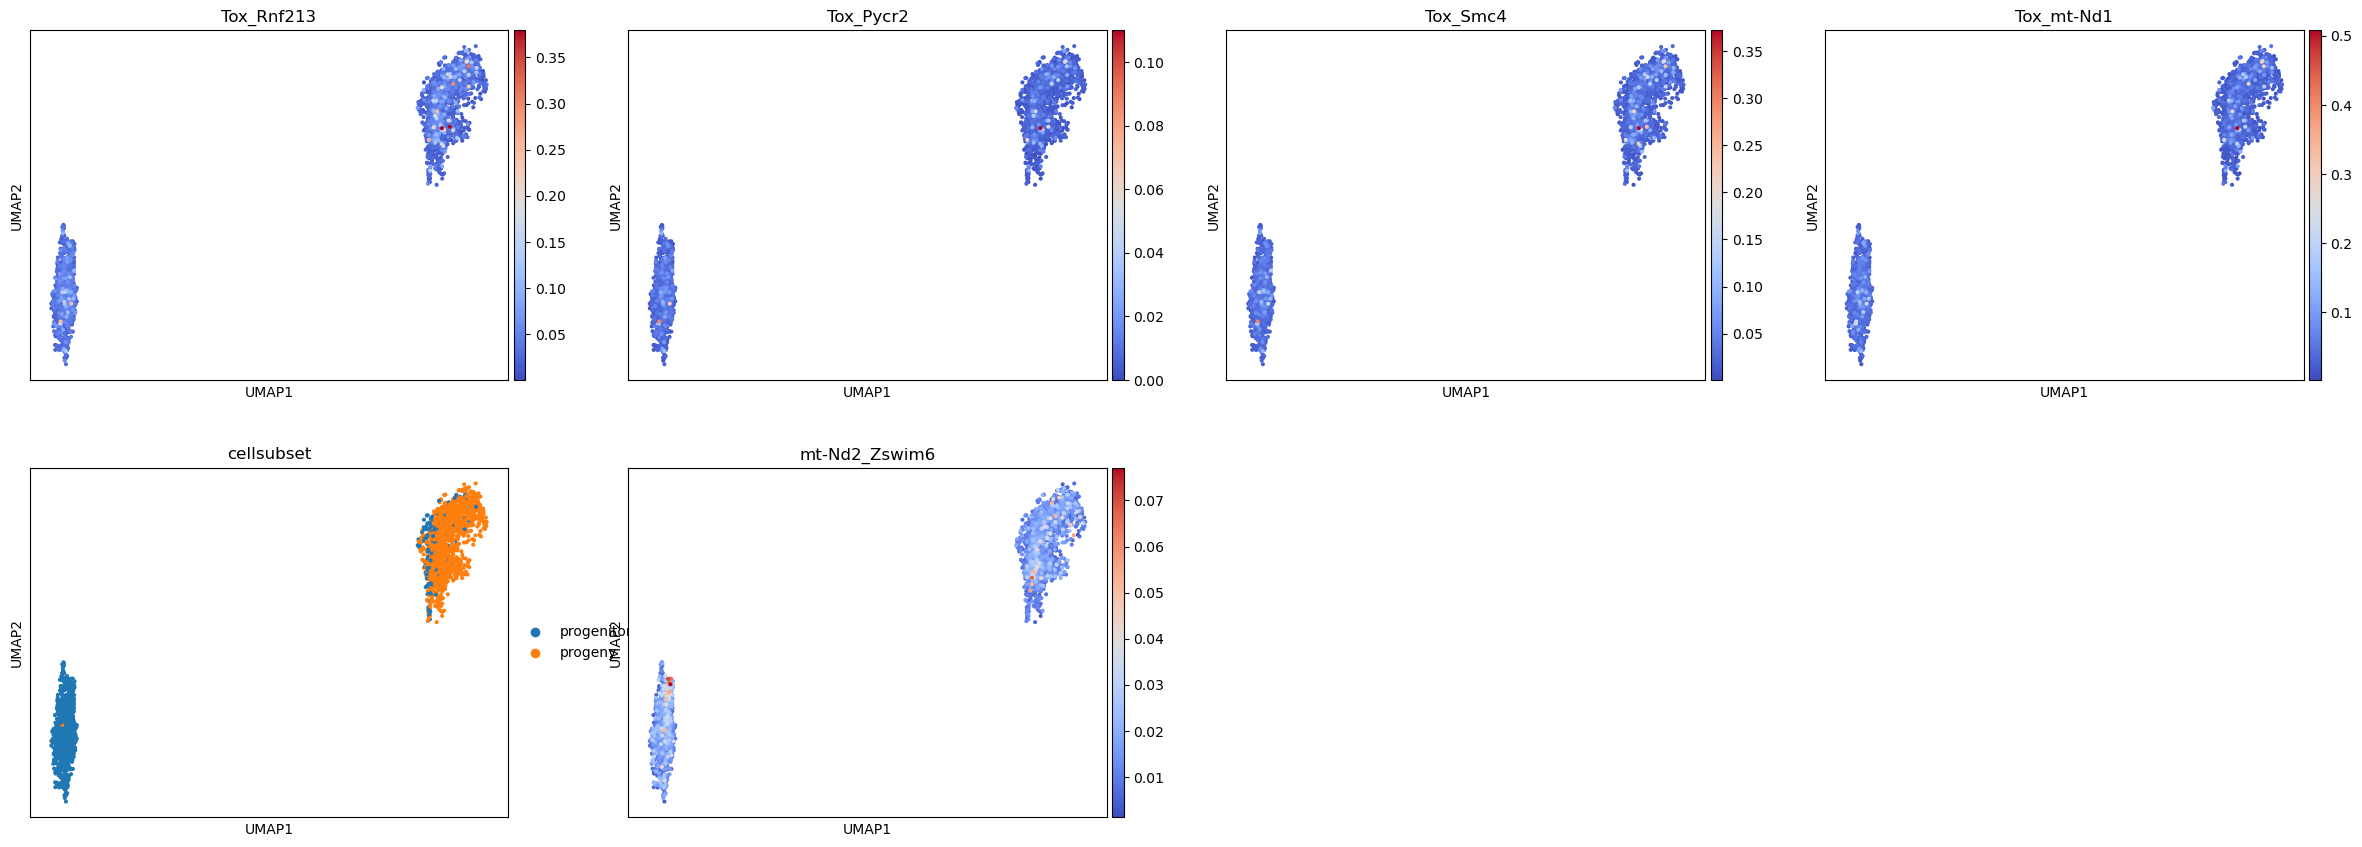

In [45]:
sc.pl.umap(aa, color = ['Tox_Rnf213', 'Tox_Pycr2','Tox_Smc4', 'Tox_mt-Nd1', 'cellsubset', 'mt-Nd2_Zswim6'], use_raw=False, cmap="coolwarm")

In [13]:
gene_inter_adata = aa.copy()
print("Gene interaintion adata")
print(gene_inter_adata)
print("\n\n Gene expression adata")
adata = adata[gene_inter_adata.obs_names,:]
adata

Gene interaintion adata
AnnData object with n_obs × n_vars = 3544 × 56981
    obs: 'leiden', 'cellsubset', 'Sample_Name', 'time', 'genotype', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellsubset_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


 Gene expression adata


KeyError: "Values ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '19', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '39', '41', '42', '43', '44', '45', '46', '47', '49', '50', '51', '52', '53', '54', '57', '60', '61', '62', '63', '64', '66', '67', '68', '69', '72', '73', '75', '79', '80', '81', '82', '83', '84', '85', '86', '87', '89', '91', '94', '95', '96', '97', '98', '99', '100', '101', '102', '104', '105', '106', '107', '108', '109', '110', '112', '113', '115', '116', '117', '118', '121', '122', '123', '125', '126', '127', '128', '130', '132', '133', '134', '136', '137', '138', '139', '140', '141', '144', '146', '147', '148', '149', '150', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '171', '172', '174', '175', '176', '177', '178', '181', '183', '184', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '203', '205', '207', '209', '211', '212', '214', '215', '216', '217', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '230', '232', '233', '234', '235', '238', '239', '240', '241', '245', '246', '248', '249', '251', '252', '253', '256', '257', '258', '260', '261', '262', '264', '265', '266', '267', '269', '270', '273', '274', '275', '276', '278', '279', '280', '281', '282', '283', '286', '287', '288', '289', '293', '294', '296', '298', '299', '300', '301', '303', '304', '306', '307', '309', '312', '313', '314', '315', '316', '317', '318', '320', '321', '323', '325', '327', '329', '330', '331', '334', '336', '337', '343', '344', '348', '349', '350', '352', '355', '357', '358', '359', '360', '361', '362', '364', '365', '367', '368', '369', '370', '371', '372', '375', '377', '378', '379', '380', '383', '388', '389', '390', '391', '392', '393', '394', '397', '398', '399', '400', '403', '404', '407', '409', '410', '412', '413', '415', '416', '418', '419', '420', '421', '422', '424', '426', '427', '430', '431', '432', '433', '435', '436', '437', '438', '441', '443', '444', '445', '446', '448', '449', '450', '451', '454', '455', '456', '457', '458', '459', '460', '463', '464', '466', '468', '471', '473', '475', '476', '477', '478', '479', '480', '481', '482', '484', '485', '486', '487', '488', '489', '490', '492', '494', '495', '498', '499', '501', '502', '504', '506', '508', '509', '512', '513', '515', '516', '518', '519', '521', '526', '528', '531', '532', '533', '534', '536', '538', '539', '540', '542', '543', '544', '545', '549', '551', '552', '553', '554', '555', '556', '557', '558', '561', '563', '564', '566', '567', '568', '571', '572', '573', '576', '577', '578', '580', '585', '587', '590', '591', '595', '597', '598', '604', '606', '608', '609', '613', '616', '618', '620', '623', '624', '625', '627', '629', '631', '632', '633', '635', '637', '638', '640', '643', '644', '646', '650', '651', '653', '655', '656', '661', '662', '668', '672', '673', '675', '678', '680', '684', '690', '692', '693', '695', '697', '699', '700', '701', '704', '705', '706', '707', '708', '709', '711', '712', '714', '715', '717', '718', '721', '722', '723', '724', '725', '726', '727', '728', '731', '733', '734', '735', '736', '739', '741', '742', '743', '747', '750', '751', '757', '758', '759', '760', '764', '771', '772', '774', '775', '776', '779', '782', '783', '784', '786', '787', '789', '793', '799', '802', '804', '806', '810', '811', '813', '815', '816', '817', '824', '825', '831', '832', '833', '837', '839', '841', '849', '850', '852', '854', '856', '859', '860', '861', '866', '867', '870', '871', '874', '875', '877', '879', '887', '888', '889', '891', '892', '893', '895', '896', '898', '902', '905', '907', '908', '911', '914', '915', '918', '920', '921', '922', '923', '924', '928', '929', '932', '933', '934', '935', '940', '942', '944', '946', '947', '948', '950', '954', '962', '963', '966', '968', '971', '972', '973', '975', '976', '977', '982', '983', '984', '985', '987', '990', '992', '993', '998', '1000', '1007', '1011', '1012', '1015', '1018', '1019', '1022', '1023', '1031', '1032', '1034', '1036', '1037', '1038', '1039', '1040', '1043', '1046', '1047', '1048', '1050', '1055', '1057', '1058', '1061', '1062', '1063', '1064', '1065', '1069', '1072', '1074', '1075', '1076', '1078', '1080', '1083', '1084', '1086', '1088', '1089', '1090', '1091', '1093', '1095', '1096', '1097', '1101', '1103', '1105', '1106', '1107', '1109', '1111', '1112', '1113', '1114', '1116', '1117', '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1127', '1129', '1131', '1132', '1133', '1134', '1136', '1139', '1142', '1143', '1144', '1145', '1147', '1149', '1150', '1152', '1155', '1156', '1157', '1160', '1162', '1164', '1165', '1166', '1170', '1171', '1173', '1176', '1177', '1178', '1179', '1181', '1182', '1183', '1184', '1185', '1188', '1190', '1194', '1195', '1196', '1197', '1198', '1200', '1201', '1203', '1207', '1208', '1210', '1211', '1212', '1213', '1214', '1218', '1219', '1220', '1221', '1224', '1225', '1226', '1231', '1232', '1233', '1234', '1236', '1238', '1239', '1240', '1241', '1244', '1246', '1247', '1249', '1250', '1251', '1253', '1256', '1257', '1259', '1260', '1262', '1264', '1265', '1266', '1267', '1268', '1269', '1270', '1271', '1272', '1273', '1275', '1276', '1277', '1278', '1279', '1280', '1283', '1285', '1286', '1287', '1288', '1289', '1290', '1291', '1292', '1294', '1295', '1296', '1297', '1298', '1300', '1304', '1305', '1307', '1310', '1311', '1313', '1316', '1317', '1318', '1320', '1321', '1322', '1325', '1326', '1327', '1328', '1329', '1330', '1331', '1334', '1336', '1338', '1339', '1340', '1341', '1345', '1346', '1348', '1349', '1350', '1353', '1354', '1355', '1358', '1359', '1360', '1361', '1363', '1366', '1368', '1369', '1370', '1372', '1373', '1374', '1375', '1376', '1378', '1379', '1380', '1381', '1382', '1383', '1384', '1385', '1386', '1389', '1391', '1392', '1395', '1396', '1397', '1398', '1399', '1401', '1402', '1403', '1404', '1405', '1407', '1412', '1413', '1414', '1416', '1417', '1419', '1420', '1421', '1423', '1424', '1426', '1427', '1428', '1429', '1430', '1431', '1432', '1433', '1434', '1435', '1436', '1438', '1440', '1442', '1446', '1447', '1448', '1449', '1452', '1453', '1454', '1459', '1461', '1463', '1466', '1469', '1476', '1477', '1479', '1480', '1482', '1484', '1487', '1488', '1489', '1491', '1492', '1493', '1494', '1497', '1499', '1502', '1503', '1504', '1505', '1509', '1510', '1512', '1513', '1517', '1519', '1520', '1522', '1523', '1524', '1525', '1526', '1527', '1529', '1530', '1531', '1532', '1535', '1537', '1539', '1543', '1544', '1545', '1546', '1547', '1552', '1556', '1559', '1561', '1562', '1563', '1566', '1568', '1570', '1575', '1576', '1577', '1578', '1579', '1584', '1589', '1590', '1591', '1594', '1596', '1597', '1598', '1599', '1601', '1602', '1604', '1605', '1606', '1607', '1609', '1610', '1611', '1612', '1613', '1615', '1617', '1618', '1619', '1621', '1622', '1627', '1628', '1629', '1630', '1631', '1633', '1635', '1640', '1641', '1643', '1644', '1645', '1646', '1648', '1649', '1650', '1652', '1653', '1655', '1656', '1657', '1658', '1660', '1665', '1666', '1667', '1668', '1669', '1672', '1673', '1674', '1675', '1676', '1679', '1681', '1682', '1683', '1685', '1686', '1688', '1689', '1690', '1692', '1694', '1695', '1696', '1697', '1699', '1701', '1702', '1703', '1704', '1706', '1707', '1709', '1711', '1713', '1714', '1715', '1716', '1717', '1719', '1721', '1723', '1724', '1725', '1726', '1727', '1728', '1730', '1732', '1735', '1736', '1737', '1739', '1740', '1741', '1742', '1744', '1745', '1746', '1748', '1749', '1750', '1751', '1752', '1755', '1757', '1759', '1760', '1764', '1765', '1767', '1768', '1769', '1770', '1771', '1772', '1773', '1775', '1777', '1778', '1779', '1782', '1783', '1784', '1786', '1787', '1788', '1789', '1791', '1792', '1793', '1794', '1795', '1796', '1797', '1799', '1800', '1801', '1802', '1803', '1804', '1805', '1808', '1809', '1810', '1812', '1813', '1815', '1817', '1819', '1822', '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1840', '1841', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1854', '1856', '1857', '1858', '1859', '1861', '1862', '1864', '1865', '1866', '1867', '1868', '1870', '1871', '1872', '1874', '1875', '1879', '1880', '1881', '1882', '1884', '1885', '1887', '1888', '1891', '1892', '1896', '1897', '1898', '1899', '1900', '1902', '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1912', '1913', '1914', '1915', '1917', '1918', '1919', '1920', '1921', '1924', '1925', '1926', '1928', '1929', '1931', '1932', '1936', '1937', '1938', '1939', '1940', '1943', '1944', '1945', '1946', '1947', '1949', '1950', '1951', '1952', '1953', '1955', '1956', '1958', '1959', '1960', '1961', '1963', '1964', '1965', '1966', '1968', '1969', '1970', '1971', '1972', '1976', '1979', '1980', '1981', '1983', '1984', '1985', '1986', '1989', '1990', '1991', '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2001', '2002', '2004', '2005', '2006', '2007', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2019', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2030', '2034', '2035', '2036', '2037', '2039', '2040', '2041', '2043', '2044', '2045', '2046', '2048', '2049', '2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2059', '2060', '2061', '2062', '2063', '2065', '2066', '2067', '2070', '2072', '2073', '2074', '2076', '2077', '2079', '2081', '2086', '2087', '2088', '2091', '2092', '2093', '2094', '2096', '2097', '2098', '2099', '2100', '2102', '2103', '2104', '2105', '2106', '2108', '2109', '2110', '2111', '2114', '2115', '2116', '2118', '2119', '2121', '2122', '2123', '2125', '2126', '2127', '2128', '2129', '2130', '2131', '2133', '2134', '2135', '2137', '2141', '2143', '2144', '2148', '2152', '2153', '2154', '2155', '2156', '2157', '2159', '2160', '2161', '2162', '2164', '2165', '2166', '2167', '2168', '2171', '2172', '2173', '2174', '2178', '2180', '2181', '2183', '2184', '2185', '2187', '2188', '2189', '2192', '2193', '2194', '2195', '2198', '2199', '2200', '2202', '2203', '2206', '2208', '2209', '2211', '2213', '2214', '2215', '2217', '2219', '2221', '2222', '2223', '2224', '2225', '2226', '2227', '2228', '2229', '2230', '2231', '2232', '2234', '2237', '2238', '2240', '2241', '2243', '2244', '2245', '2247', '2250', '2251', '2253', '2254', '2255', '2256', '2257', '2258', '2259', '2261', '2263', '2264', '2265', '2266', '2267', '2268', '2270', '2271', '2272', '2273', '2275', '2278', '2279', '2280', '2283', '2285', '2288', '2290', '2294', '2295', '2297', '2299', '2300', '2301', '2302', '2303', '2304', '2306', '2307', '2308', '2309', '2310', '2312', '2313', '2314', '2315', '2316', '2317', '2318', '2320', '2321', '2322', '2325', '2326', '2328', '2330', '2332', '2333', '2335', '2336', '2338', '2339', '2340', '2343', '2344', '2345', '2348', '2349', '2350', '2351', '2353', '2354', '2355', '2357', '2358', '2359', '2360', '2362', '2363', '2364', '2365', '2366', '2367', '2368', '2369', '2370', '2371', '2374', '2377', '2382', '2383', '2384', '2388', '2390', '2391', '2392', '2393', '2396', '2397', '2398', '2399', '2400', '2405', '2406', '2407', '2408', '2409', '2412', '2414', '2415', '2417', '2419', '2420', '2421', '2422', '2423', '2424', '2425', '2426', '2427', '2429', '2430', '2431', '2432', '2434', '2435', '2436', '2438', '2439', '2442', '2443', '2447', '2448', '2449', '2450', '2452', '2453', '2454', '2456', '2457', '2458', '2460', '2461', '2463', '2466', '2467', '2471', '2472', '2474', '2475', '2476', '2477', '2478', '2479', '2480', '2481', '2483', '2484', '2485', '2486', '2489', '2490', '2494', '2495', '2496', '2497', '2498', '2499', '2501', '2502', '2503', '2505', '2507', '2508', '2510', '2511', '2512', '2513', '2515', '2518', '2519', '2520', '2521', '2525', '2526', '2527', '2528', '2531', '2533', '2535', '2540', '2541', '2546', '2548', '2549', '2550', '2553', '2555', '2556', '2558', '2560', '2561', '2563', '2564', '2566', '2567', '2568', '2569', '2571', '2572', '2574', '2577', '2579', '2584', '2587', '2589', '2591', '2592', '2593', '2594', '2595', '2598', '2600', '2603', '2606', '2607', '2609', '2610', '2612', '2613', '2615', '2617', '2621', '2622', '2623', '2626', '2631', '2632', '2633', '2636', '2637', '2639', '2643', '2644', '2647', '2648', '2649', '2652', '2656', '2657', '2658', '2660', '2665', '2666', '2667', '2668', '2669', '2670', '2671', '2672', '2673', '2676', '2677', '2679', '2681', '2682', '2683', '2686', '2687', '2688', '2689', '2690', '2691', '2692', '2695', '2696', '2697', '2698', '2700', '2701', '2702', '2703', '2706', '2707', '2709', '2710', '2715', '2718', '2721', '2724', '2726', '2727', '2728', '2729', '2731', '2732', '2733', '2734', '2736', '2739', '2740', '2743', '2745', '2748', '2750', '2752', '2753', '2754', '2756', '2759', '2764', '2765', '2766', '2768', '2769', '2770', '2771', '2772', '2776', '2778', '2779', '2780', '2787', '2789', '2791', '2792', '2793', '2794', '2796', '2797', '2799', '2800', '2802', '2803', '2804', '2805', '2806', '2809', '2811', '2813', '2814', '2815', '2816', '2817', '2818', '2819', '2820', '2821', '2823', '2824', '2825', '2826', '2829', '2830', '2831', '2833', '2834', '2835', '2836', '2839', '2840', '2842', '2843', '2846', '2847', '2848', '2850', '2851', '2854', '2857', '2860', '2863', '2865', '2866', '2868', '2869', '2871', '2872', '2874', '2876', '2877', '2880', '2883', '2885', '2886', '2888', '2889', '2890', '2891', '2892', '2893', '2895', '2896', '2897', '2900', '2902', '2903', '2904', '2907', '2908', '2910', '2911', '2912', '2916', '2917', '2920', '2921', '2925', '2926', '2929', '2933', '2935', '2936', '2941', '2942', '2943', '2946', '2947', '2948', '2950', '2951', '2953', '2954', '2955', '2957', '2958', '2963', '2964', '2965', '2969', '2971', '2973', '2975', '2976', '2979', '2980', '2981', '2984', '2985', '2986', '2988', '2989', '2993', '2994', '2995', '2997', '2998', '2999', '3001', '3003', '3004', '3006', '3008', '3009', '3011', '3013', '3015', '3017', '3018', '3019', '3024', '3026', '3027', '3028', '3029', '3031', '3036', '3037', '3038', '3039', '3041', '3042', '3044', '3045', '3047', '3048', '3049', '3050', '3054', '3057', '3059', '3060', '3062', '3066', '3068', '3069', '3073', '3074', '3075', '3077', '3079', '3081', '3082', '3083', '3084', '3086', '3088', '3089', '3092', '3093', '3094', '3098', '3099', '3100', '3102', '3104', '3105', '3106', '3107', '3110', '3112', '3115', '3116', '3117', '3121', '3126', '3128', '3129', '3130', '3134', '3136', '3139', '3143', '3144', '3145', '3146', '3147', '3148', '3149', '3151', '3152', '3153', '3154', '3157', '3160', '3162', '3164', '3165', '3166', '3167', '3168', '3169', '3170', '3171', '3172', '3173', '3177', '3178', '3179', '3180', '3181', '3185', '3186', '3187', '3188', '3191', '3192', '3193', '3194', '3199', '3200', '3202', '3203', '3204', '3207', '3208', '3209', '3213', '3214', '3217', '3218', '3221', '3225', '3227', '3228', '3229', '3230', '3231', '3233', '3235', '3236', '3237', '3239', '3240', '3241', '3243', '3245', '3246', '3248', '3250', '3252', '3253', '3254', '3255', '3258', '3259', '3260', '3261', '3262', '3266', '3268', '3269', '3270', '3274', '3275', '3276', '3277', '3278', '3279', '3280', '3281', '3282', '3283', '3284', '3287', '3288', '3289', '3293', '3294', '3296', '3297', '3298', '3299', '3302', '3303', '3304', '3306', '3307', '3308', '3309', '3312', '3315', '3318', '3320', '3328', '3329', '3332', '3333', '3334', '3336', '3337', '3338', '3339', '3341', '3342', '3343', '3344', '3345', '3347', '3348', '3351', '3354', '3356', '3357', '3358', '3360', '3361', '3363', '3364', '3365', '3366', '3367', '3370', '3372', '3373', '3374', '3375', '3376', '3380', '3381', '3384', '3386', '3389', '3390', '3391', '3392', '3393', '3395', '3396', '3397', '3401', '3405', '3406', '3407', '3409', '3411', '3414', '3418', '3421', '3422', '3424', '3426', '3427', '3428', '3429', '3431', '3433', '3440', '3441', '3444', '3446', '3447', '3448', '3449', '3451', '3452', '3454', '3456', '3458', '3461', '3463', '3464', '3466', '3470', '3471', '3472', '3477', '3480', '3481', '3482', '3483', '3484', '3485', '3487', '3490', '3492', '3494', '3495', '3497', '3498', '3502', '3503', '3507', '3508', '3509', '3511', '3512', '3514', '3517', '3518', '3521', '3522', '3524', '3525', '3526', '3527', '3528', '3529', '3530', '3531', '3533', '3535', '3536', '3537', '3538', '3539', '3541', '3542', '3543', '12', '18', '20', '21', '22', '36', '37', '38', '40', '48', '55', '56', '58', '59', '65', '70', '71', '74', '76', '77', '78', '88', '90', '92', '93', '103', '111', '114', '119', '120', '124', '129', '131', '135', '142', '143', '145', '151', '152', '170', '173', '179', '180', '182', '185', '186', '198', '202', '204', '206', '208', '210', '213', '218', '229', '231', '236', '237', '242', '243', '244', '247', '250', '254', '255', '259', '263', '268', '271', '272', '277', '284', '285', '290', '291', '292', '295', '297', '302', '305', '308', '310', '311', '319', '322', '324', '326', '328', '332', '333', '335', '338', '339', '340', '341', '342', '345', '346', '347', '351', '353', '354', '356', '363', '366', '373', '374', '376', '381', '382', '384', '385', '386', '387', '395', '396', '401', '402', '405', '406', '408', '411', '414', '417', '423', '425', '428', '429', '434', '439', '440', '442', '447', '452', '453', '461', '462', '465', '467', '469', '470', '472', '474', '483', '491', '493', '496', '497', '500', '503', '505', '507', '510', '511', '514', '517', '520', '522', '523', '524', '525', '527', '529', '530', '535', '537', '541', '546', '547', '548', '550', '559', '560', '562', '565', '569', '570', '574', '575', '579', '581', '582', '583', '584', '586', '588', '589', '592', '593', '594', '596', '599', '600', '601', '602', '603', '605', '607', '610', '611', '612', '614', '615', '617', '619', '621', '622', '626', '628', '630', '634', '636', '639', '641', '642', '645', '647', '648', '649', '652', '654', '657', '658', '659', '660', '663', '664', '665', '666', '667', '669', '670', '671', '674', '676', '677', '679', '681', '682', '683', '685', '686', '687', '688', '689', '691', '694', '696', '698', '702', '703', '710', '713', '716', '719', '720', '729', '730', '732', '737', '738', '740', '744', '745', '746', '748', '749', '752', '753', '754', '755', '756', '761', '762', '763', '765', '766', '767', '768', '769', '770', '773', '777', '778', '780', '781', '785', '788', '790', '791', '792', '794', '795', '796', '797', '798', '800', '801', '803', '805', '807', '808', '809', '812', '814', '818', '819', '820', '821', '822', '823', '826', '827', '828', '829', '830', '834', '835', '836', '838', '840', '842', '843', '844', '845', '846', '847', '848', '851', '853', '855', '857', '858', '862', '863', '864', '865', '868', '869', '872', '873', '876', '878', '880', '881', '882', '883', '884', '885', '886', '890', '894', '897', '899', '900', '901', '903', '904', '906', '909', '910', '912', '913', '916', '917', '919', '925', '926', '927', '930', '931', '936', '937', '938', '939', '941', '943', '945', '949', '951', '952', '953', '955', '956', '957', '958', '959', '960', '961', '964', '965', '967', '969', '970', '974', '978', '979', '980', '981', '986', '988', '989', '991', '994', '995', '996', '997', '999', '1001', '1002', '1003', '1004', '1005', '1006', '1008', '1009', '1010', '1013', '1014', '1016', '1017', '1020', '1021', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1033', '1035', '1041', '1042', '1044', '1045', '1049', '1051', '1052', '1053', '1054', '1056', '1059', '1060', '1066', '1067', '1068', '1070', '1071', '1073', '1077', '1079', '1081', '1082', '1085', '1087', '1092', '1094', '1098', '1099', '1100', '1102', '1104', '1108', '1110', '1115', '1118', '1126', '1128', '1130', '1135', '1137', '1138', '1140', '1141', '1146', '1148', '1151', '1153', '1154', '1158', '1159', '1161', '1163', '1167', '1168', '1169', '1172', '1174', '1175', '1180', '1186', '1187', '1189', '1191', '1192', '1193', '1199', '1202', '1204', '1205', '1206', '1209', '1215', '1216', '1217', '1222', '1223', '1227', '1228', '1229', '1230', '1235', '1237', '1242', '1243', '1245', '1248', '1252', '1254', '1255', '1258', '1261', '1263', '1274', '1281', '1282', '1284', '1293', '1299', '1301', '1302', '1303', '1306', '1308', '1309', '1312', '1314', '1315', '1319', '1323', '1324', '1332', '1333', '1335', '1337', '1342', '1343', '1344', '1347', '1351', '1352', '1356', '1357', '1362', '1364', '1365', '1367', '1371', '1377', '1387', '1388', '1390', '1393', '1394', '1400', '1406', '1408', '1409', '1410', '1411', '1415', '1418', '1422', '1425', '1437', '1439', '1441', '1443', '1444', '1445', '1450', '1451', '1455', '1456', '1457', '1458', '1460', '1462', '1464', '1465', '1467', '1468', '1470', '1471', '1472', '1473', '1474', '1475', '1478', '1481', '1483', '1485', '1486', '1490', '1495', '1496', '1498', '1500', '1501', '1506', '1507', '1508', '1511', '1514', '1515', '1516', '1518', '1521', '1528', '1533', '1534', '1536', '1538', '1540', '1541', '1542', '1548', '1549', '1550', '1551', '1553', '1554', '1555', '1557', '1558', '1560', '1564', '1565', '1567', '1569', '1571', '1572', '1573', '1574', '1580', '1581', '1582', '1583', '1585', '1586', '1587', '1588', '1592', '1593', '1595', '1600', '1603', '1608', '1614', '1616', '1620', '1623', '1624', '1625', '1626', '1632', '1634', '1636', '1637', '1638', '1639', '1642', '1647', '1651', '1654', '1659', '1661', '1662', '1663', '1664', '1670', '1671', '1677', '1678', '1680', '1684', '1687', '1691', '1693', '1698', '1700', '1705', '1708', '1710', '1712', '1718', '1720', '1722', '1729', '1731', '1733', '1734', '1738', '1743', '1747', '1753', '1754', '1756', '1758', '1761', '1762', '1763', '1766', '1774', '1776', '1780', '1781', '1785', '1790', '1798', '1806', '1807', '1811', '1814', '1816', '1818', '1820', '1821', '1826', '1827', '1839', '1842', '1852', '1853', '1855', '1860', '1863', '1869', '1873', '1876', '1877', '1878', '1883', '1886', '1889', '1890', '1893', '1894', '1895', '1901', '1904', '1911', '1916', '1922', '1923', '1927', '1930', '1933', '1934', '1935', '1941', '1942', '1948', '1954', '1957', '1962', '1967', '1973', '1974', '1975', '1977', '1978', '1982', '1987', '1988', '1994', '2000', '2003', '2008', '2009', '2010', '2018', '2020', '2029', '2031', '2032', '2033', '2038', '2042', '2047', '2058', '2064', '2068', '2069', '2071', '2075', '2078', '2080', '2082', '2083', '2084', '2085', '2089', '2090', '2095', '2101', '2107', '2112', '2113', '2117', '2120', '2124', '2132', '2136', '2138', '2139', '2140', '2142', '2145', '2146', '2147', '2149', '2150', '2151', '2158', '2163', '2169', '2170', '2175', '2176', '2177', '2179', '2182', '2186', '2190', '2191', '2196', '2197', '2201', '2204', '2205', '2207', '2210', '2212', '2216', '2218', '2220', '2233', '2235', '2236', '2239', '2242', '2246', '2248', '2249', '2252', '2260', '2262', '2269', '2274', '2276', '2277', '2281', '2282', '2284', '2286', '2287', '2289', '2291', '2292', '2293', '2296', '2298', '2305', '2311', '2319', '2323', '2324', '2327', '2329', '2331', '2334', '2337', '2341', '2342', '2346', '2347', '2352', '2356', '2361', '2372', '2373', '2375', '2376', '2378', '2379', '2380', '2381', '2385', '2386', '2387', '2389', '2394', '2395', '2401', '2402', '2403', '2404', '2410', '2411', '2413', '2416', '2418', '2428', '2433', '2437', '2440', '2441', '2444', '2445', '2446', '2451', '2455', '2459', '2462', '2464', '2465', '2468', '2469', '2470', '2473', '2482', '2487', '2488', '2491', '2492', '2493', '2500', '2504', '2506', '2509', '2514', '2516', '2517', '2522', '2523', '2524', '2529', '2530', '2532', '2534', '2536', '2537', '2538', '2539', '2542', '2543', '2544', '2545', '2547', '2551', '2552', '2554', '2557', '2559', '2562', '2565', '2570', '2573', '2575', '2576', '2578', '2580', '2581', '2582', '2583', '2585', '2586', '2588', '2590', '2596', '2597', '2599', '2601', '2602', '2604', '2605', '2608', '2611', '2614', '2616', '2618', '2619', '2620', '2624', '2625', '2627', '2628', '2629', '2630', '2634', '2635', '2638', '2640', '2641', '2642', '2645', '2646', '2650', '2651', '2653', '2654', '2655', '2659', '2661', '2662', '2663', '2664', '2674', '2675', '2678', '2680', '2684', '2685', '2693', '2694', '2699', '2704', '2705', '2708', '2711', '2712', '2713', '2714', '2716', '2717', '2719', '2720', '2722', '2723', '2725', '2730', '2735', '2737', '2738', '2741', '2742', '2744', '2746', '2747', '2749', '2751', '2755', '2757', '2758', '2760', '2761', '2762', '2763', '2767', '2773', '2774', '2775', '2777', '2781', '2782', '2783', '2784', '2785', '2786', '2788', '2790', '2795', '2798', '2801', '2807', '2808', '2810', '2812', '2822', '2827', '2828', '2832', '2837', '2838', '2841', '2844', '2845', '2849', '2852', '2853', '2855', '2856', '2858', '2859', '2861', '2862', '2864', '2867', '2870', '2873', '2875', '2878', '2879', '2881', '2882', '2884', '2887', '2894', '2898', '2899', '2901', '2905', '2906', '2909', '2913', '2914', '2915', '2918', '2919', '2922', '2923', '2924', '2927', '2928', '2930', '2931', '2932', '2934', '2937', '2938', '2939', '2940', '2944', '2945', '2949', '2952', '2956', '2959', '2960', '2961', '2962', '2966', '2967', '2968', '2970', '2972', '2974', '2977', '2978', '2982', '2983', '2987', '2990', '2991', '2992', '2996', '3000', '3002', '3005', '3007', '3010', '3012', '3014', '3016', '3020', '3021', '3022', '3023', '3025', '3030', '3032', '3033', '3034', '3035', '3040', '3043', '3046', '3051', '3052', '3053', '3055', '3056', '3058', '3061', '3063', '3064', '3065', '3067', '3070', '3071', '3072', '3076', '3078', '3080', '3085', '3087', '3090', '3091', '3095', '3096', '3097', '3101', '3103', '3108', '3109', '3111', '3113', '3114', '3118', '3119', '3120', '3122', '3123', '3124', '3125', '3127', '3131', '3132', '3133', '3135', '3137', '3138', '3140', '3141', '3142', '3150', '3155', '3156', '3158', '3159', '3161', '3163', '3174', '3175', '3176', '3182', '3183', '3184', '3189', '3190', '3195', '3196', '3197', '3198', '3201', '3205', '3206', '3210', '3211', '3212', '3215', '3216', '3219', '3220', '3222', '3223', '3224', '3226', '3232', '3234', '3238', '3242', '3244', '3247', '3249', '3251', '3256', '3257', '3263', '3264', '3265', '3267', '3271', '3272', '3273', '3285', '3286', '3290', '3291', '3292', '3295', '3300', '3301', '3305', '3310', '3311', '3313', '3314', '3316', '3317', '3319', '3321', '3322', '3323', '3324', '3325', '3326', '3327', '3330', '3331', '3335', '3340', '3346', '3349', '3350', '3352', '3353', '3355', '3359', '3362', '3368', '3369', '3371', '3377', '3378', '3379', '3382', '3383', '3385', '3387', '3388', '3394', '3398', '3399', '3400', '3402', '3403', '3404', '3408', '3410', '3412', '3413', '3415', '3416', '3417', '3419', '3420', '3423', '3425', '3430', '3432', '3434', '3435', '3436', '3437', '3438', '3439', '3442', '3443', '3445', '3450', '3453', '3455', '3457', '3459', '3460', '3462', '3465', '3467', '3468', '3469', '3473', '3474', '3475', '3476', '3478', '3479', '3486', '3488', '3489', '3491', '3493', '3496', '3499', '3500', '3501', '3504', '3505', '3506', '3510', '3513', '3515', '3516', '3519', '3520', '3523', '3532', '3534', '3540'], from ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '19', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '39', '41', '42', '43', '44', '45', '46', '47', '49', '50', '51', '52', '53', '54', '57', '60', '61', '62', '63', '64', '66', '67', '68', '69', '72', '73', '75', '79', '80', '81', '82', '83', '84', '85', '86', '87', '89', '91', '94', '95', '96', '97', '98', '99', '100', '101', '102', '104', '105', '106', '107', '108', '109', '110', '112', '113', '115', '116', '117', '118', '121', '122', '123', '125', '126', '127', '128', '130', '132', '133', '134', '136', '137', '138', '139', '140', '141', '144', '146', '147', '148', '149', '150', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '171', '172', '174', '175', '176', '177', '178', '181', '183', '184', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '199', '200', '201', '203', '205', '207', '209', '211', '212', '214', '215', '216', '217', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '230', '232', '233', '234', '235', '238', '239', '240', '241', '245', '246', '248', '249', '251', '252', '253', '256', '257', '258', '260', '261', '262', '264', '265', '266', '267', '269', '270', '273', '274', '275', '276', '278', '279', '280', '281', '282', '283', '286', '287', '288', '289', '293', '294', '296', '298', '299', '300', '301', '303', '304', '306', '307', '309', '312', '313', '314', '315', '316', '317', '318', '320', '321', '323', '325', '327', '329', '330', '331', '334', '336', '337', '343', '344', '348', '349', '350', '352', '355', '357', '358', '359', '360', '361', '362', '364', '365', '367', '368', '369', '370', '371', '372', '375', '377', '378', '379', '380', '383', '388', '389', '390', '391', '392', '393', '394', '397', '398', '399', '400', '403', '404', '407', '409', '410', '412', '413', '415', '416', '418', '419', '420', '421', '422', '424', '426', '427', '430', '431', '432', '433', '435', '436', '437', '438', '441', '443', '444', '445', '446', '448', '449', '450', '451', '454', '455', '456', '457', '458', '459', '460', '463', '464', '466', '468', '471', '473', '475', '476', '477', '478', '479', '480', '481', '482', '484', '485', '486', '487', '488', '489', '490', '492', '494', '495', '498', '499', '501', '502', '504', '506', '508', '509', '512', '513', '515', '516', '518', '519', '521', '526', '528', '531', '532', '533', '534', '536', '538', '539', '540', '542', '543', '544', '545', '549', '551', '552', '553', '554', '555', '556', '557', '558', '561', '563', '564', '566', '567', '568', '571', '572', '573', '576', '577', '578', '580', '585', '587', '590', '591', '595', '597', '598', '604', '606', '608', '609', '613', '616', '618', '620', '623', '624', '625', '627', '629', '631', '632', '633', '635', '637', '638', '640', '643', '644', '646', '650', '651', '653', '655', '656', '661', '662', '668', '672', '673', '675', '678', '680', '684', '690', '692', '693', '695', '697', '699', '700', '701', '704', '705', '706', '707', '708', '709', '711', '712', '714', '715', '717', '718', '721', '722', '723', '724', '725', '726', '727', '728', '731', '733', '734', '735', '736', '739', '741', '742', '743', '747', '750', '751', '757', '758', '759', '760', '764', '771', '772', '774', '775', '776', '779', '782', '783', '784', '786', '787', '789', '793', '799', '802', '804', '806', '810', '811', '813', '815', '816', '817', '824', '825', '831', '832', '833', '837', '839', '841', '849', '850', '852', '854', '856', '859', '860', '861', '866', '867', '870', '871', '874', '875', '877', '879', '887', '888', '889', '891', '892', '893', '895', '896', '898', '902', '905', '907', '908', '911', '914', '915', '918', '920', '921', '922', '923', '924', '928', '929', '932', '933', '934', '935', '940', '942', '944', '946', '947', '948', '950', '954', '962', '963', '966', '968', '971', '972', '973', '975', '976', '977', '982', '983', '984', '985', '987', '990', '992', '993', '998', '1000', '1007', '1011', '1012', '1015', '1018', '1019', '1022', '1023', '1031', '1032', '1034', '1036', '1037', '1038', '1039', '1040', '1043', '1046', '1047', '1048', '1050', '1055', '1057', '1058', '1061', '1062', '1063', '1064', '1065', '1069', '1072', '1074', '1075', '1076', '1078', '1080', '1083', '1084', '1086', '1088', '1089', '1090', '1091', '1093', '1095', '1096', '1097', '1101', '1103', '1105', '1106', '1107', '1109', '1111', '1112', '1113', '1114', '1116', '1117', '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1127', '1129', '1131', '1132', '1133', '1134', '1136', '1139', '1142', '1143', '1144', '1145', '1147', '1149', '1150', '1152', '1155', '1156', '1157', '1160', '1162', '1164', '1165', '1166', '1170', '1171', '1173', '1176', '1177', '1178', '1179', '1181', '1182', '1183', '1184', '1185', '1188', '1190', '1194', '1195', '1196', '1197', '1198', '1200', '1201', '1203', '1207', '1208', '1210', '1211', '1212', '1213', '1214', '1218', '1219', '1220', '1221', '1224', '1225', '1226', '1231', '1232', '1233', '1234', '1236', '1238', '1239', '1240', '1241', '1244', '1246', '1247', '1249', '1250', '1251', '1253', '1256', '1257', '1259', '1260', '1262', '1264', '1265', '1266', '1267', '1268', '1269', '1270', '1271', '1272', '1273', '1275', '1276', '1277', '1278', '1279', '1280', '1283', '1285', '1286', '1287', '1288', '1289', '1290', '1291', '1292', '1294', '1295', '1296', '1297', '1298', '1300', '1304', '1305', '1307', '1310', '1311', '1313', '1316', '1317', '1318', '1320', '1321', '1322', '1325', '1326', '1327', '1328', '1329', '1330', '1331', '1334', '1336', '1338', '1339', '1340', '1341', '1345', '1346', '1348', '1349', '1350', '1353', '1354', '1355', '1358', '1359', '1360', '1361', '1363', '1366', '1368', '1369', '1370', '1372', '1373', '1374', '1375', '1376', '1378', '1379', '1380', '1381', '1382', '1383', '1384', '1385', '1386', '1389', '1391', '1392', '1395', '1396', '1397', '1398', '1399', '1401', '1402', '1403', '1404', '1405', '1407', '1412', '1413', '1414', '1416', '1417', '1419', '1420', '1421', '1423', '1424', '1426', '1427', '1428', '1429', '1430', '1431', '1432', '1433', '1434', '1435', '1436', '1438', '1440', '1442', '1446', '1447', '1448', '1449', '1452', '1453', '1454', '1459', '1461', '1463', '1466', '1469', '1476', '1477', '1479', '1480', '1482', '1484', '1487', '1488', '1489', '1491', '1492', '1493', '1494', '1497', '1499', '1502', '1503', '1504', '1505', '1509', '1510', '1512', '1513', '1517', '1519', '1520', '1522', '1523', '1524', '1525', '1526', '1527', '1529', '1530', '1531', '1532', '1535', '1537', '1539', '1543', '1544', '1545', '1546', '1547', '1552', '1556', '1559', '1561', '1562', '1563', '1566', '1568', '1570', '1575', '1576', '1577', '1578', '1579', '1584', '1589', '1590', '1591', '1594', '1596', '1597', '1598', '1599', '1601', '1602', '1604', '1605', '1606', '1607', '1609', '1610', '1611', '1612', '1613', '1615', '1617', '1618', '1619', '1621', '1622', '1627', '1628', '1629', '1630', '1631', '1633', '1635', '1640', '1641', '1643', '1644', '1645', '1646', '1648', '1649', '1650', '1652', '1653', '1655', '1656', '1657', '1658', '1660', '1665', '1666', '1667', '1668', '1669', '1672', '1673', '1674', '1675', '1676', '1679', '1681', '1682', '1683', '1685', '1686', '1688', '1689', '1690', '1692', '1694', '1695', '1696', '1697', '1699', '1701', '1702', '1703', '1704', '1706', '1707', '1709', '1711', '1713', '1714', '1715', '1716', '1717', '1719', '1721', '1723', '1724', '1725', '1726', '1727', '1728', '1730', '1732', '1735', '1736', '1737', '1739', '1740', '1741', '1742', '1744', '1745', '1746', '1748', '1749', '1750', '1751', '1752', '1755', '1757', '1759', '1760', '1764', '1765', '1767', '1768', '1769', '1770', '1771', '1772', '1773', '1775', '1777', '1778', '1779', '1782', '1783', '1784', '1786', '1787', '1788', '1789', '1791', '1792', '1793', '1794', '1795', '1796', '1797', '1799', '1800', '1801', '1802', '1803', '1804', '1805', '1808', '1809', '1810', '1812', '1813', '1815', '1817', '1819', '1822', '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1840', '1841', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1854', '1856', '1857', '1858', '1859', '1861', '1862', '1864', '1865', '1866', '1867', '1868', '1870', '1871', '1872', '1874', '1875', '1879', '1880', '1881', '1882', '1884', '1885', '1887', '1888', '1891', '1892', '1896', '1897', '1898', '1899', '1900', '1902', '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1912', '1913', '1914', '1915', '1917', '1918', '1919', '1920', '1921', '1924', '1925', '1926', '1928', '1929', '1931', '1932', '1936', '1937', '1938', '1939', '1940', '1943', '1944', '1945', '1946', '1947', '1949', '1950', '1951', '1952', '1953', '1955', '1956', '1958', '1959', '1960', '1961', '1963', '1964', '1965', '1966', '1968', '1969', '1970', '1971', '1972', '1976', '1979', '1980', '1981', '1983', '1984', '1985', '1986', '1989', '1990', '1991', '1992', '1993', '1995', '1996', '1997', '1998', '1999', '2001', '2002', '2004', '2005', '2006', '2007', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2019', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2030', '2034', '2035', '2036', '2037', '2039', '2040', '2041', '2043', '2044', '2045', '2046', '2048', '2049', '2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2059', '2060', '2061', '2062', '2063', '2065', '2066', '2067', '2070', '2072', '2073', '2074', '2076', '2077', '2079', '2081', '2086', '2087', '2088', '2091', '2092', '2093', '2094', '2096', '2097', '2098', '2099', '2100', '2102', '2103', '2104', '2105', '2106', '2108', '2109', '2110', '2111', '2114', '2115', '2116', '2118', '2119', '2121', '2122', '2123', '2125', '2126', '2127', '2128', '2129', '2130', '2131', '2133', '2134', '2135', '2137', '2141', '2143', '2144', '2148', '2152', '2153', '2154', '2155', '2156', '2157', '2159', '2160', '2161', '2162', '2164', '2165', '2166', '2167', '2168', '2171', '2172', '2173', '2174', '2178', '2180', '2181', '2183', '2184', '2185', '2187', '2188', '2189', '2192', '2193', '2194', '2195', '2198', '2199', '2200', '2202', '2203', '2206', '2208', '2209', '2211', '2213', '2214', '2215', '2217', '2219', '2221', '2222', '2223', '2224', '2225', '2226', '2227', '2228', '2229', '2230', '2231', '2232', '2234', '2237', '2238', '2240', '2241', '2243', '2244', '2245', '2247', '2250', '2251', '2253', '2254', '2255', '2256', '2257', '2258', '2259', '2261', '2263', '2264', '2265', '2266', '2267', '2268', '2270', '2271', '2272', '2273', '2275', '2278', '2279', '2280', '2283', '2285', '2288', '2290', '2294', '2295', '2297', '2299', '2300', '2301', '2302', '2303', '2304', '2306', '2307', '2308', '2309', '2310', '2312', '2313', '2314', '2315', '2316', '2317', '2318', '2320', '2321', '2322', '2325', '2326', '2328', '2330', '2332', '2333', '2335', '2336', '2338', '2339', '2340', '2343', '2344', '2345', '2348', '2349', '2350', '2351', '2353', '2354', '2355', '2357', '2358', '2359', '2360', '2362', '2363', '2364', '2365', '2366', '2367', '2368', '2369', '2370', '2371', '2374', '2377', '2382', '2383', '2384', '2388', '2390', '2391', '2392', '2393', '2396', '2397', '2398', '2399', '2400', '2405', '2406', '2407', '2408', '2409', '2412', '2414', '2415', '2417', '2419', '2420', '2421', '2422', '2423', '2424', '2425', '2426', '2427', '2429', '2430', '2431', '2432', '2434', '2435', '2436', '2438', '2439', '2442', '2443', '2447', '2448', '2449', '2450', '2452', '2453', '2454', '2456', '2457', '2458', '2460', '2461', '2463', '2466', '2467', '2471', '2472', '2474', '2475', '2476', '2477', '2478', '2479', '2480', '2481', '2483', '2484', '2485', '2486', '2489', '2490', '2494', '2495', '2496', '2497', '2498', '2499', '2501', '2502', '2503', '2505', '2507', '2508', '2510', '2511', '2512', '2513', '2515', '2518', '2519', '2520', '2521', '2525', '2526', '2527', '2528', '2531', '2533', '2535', '2540', '2541', '2546', '2548', '2549', '2550', '2553', '2555', '2556', '2558', '2560', '2561', '2563', '2564', '2566', '2567', '2568', '2569', '2571', '2572', '2574', '2577', '2579', '2584', '2587', '2589', '2591', '2592', '2593', '2594', '2595', '2598', '2600', '2603', '2606', '2607', '2609', '2610', '2612', '2613', '2615', '2617', '2621', '2622', '2623', '2626', '2631', '2632', '2633', '2636', '2637', '2639', '2643', '2644', '2647', '2648', '2649', '2652', '2656', '2657', '2658', '2660', '2665', '2666', '2667', '2668', '2669', '2670', '2671', '2672', '2673', '2676', '2677', '2679', '2681', '2682', '2683', '2686', '2687', '2688', '2689', '2690', '2691', '2692', '2695', '2696', '2697', '2698', '2700', '2701', '2702', '2703', '2706', '2707', '2709', '2710', '2715', '2718', '2721', '2724', '2726', '2727', '2728', '2729', '2731', '2732', '2733', '2734', '2736', '2739', '2740', '2743', '2745', '2748', '2750', '2752', '2753', '2754', '2756', '2759', '2764', '2765', '2766', '2768', '2769', '2770', '2771', '2772', '2776', '2778', '2779', '2780', '2787', '2789', '2791', '2792', '2793', '2794', '2796', '2797', '2799', '2800', '2802', '2803', '2804', '2805', '2806', '2809', '2811', '2813', '2814', '2815', '2816', '2817', '2818', '2819', '2820', '2821', '2823', '2824', '2825', '2826', '2829', '2830', '2831', '2833', '2834', '2835', '2836', '2839', '2840', '2842', '2843', '2846', '2847', '2848', '2850', '2851', '2854', '2857', '2860', '2863', '2865', '2866', '2868', '2869', '2871', '2872', '2874', '2876', '2877', '2880', '2883', '2885', '2886', '2888', '2889', '2890', '2891', '2892', '2893', '2895', '2896', '2897', '2900', '2902', '2903', '2904', '2907', '2908', '2910', '2911', '2912', '2916', '2917', '2920', '2921', '2925', '2926', '2929', '2933', '2935', '2936', '2941', '2942', '2943', '2946', '2947', '2948', '2950', '2951', '2953', '2954', '2955', '2957', '2958', '2963', '2964', '2965', '2969', '2971', '2973', '2975', '2976', '2979', '2980', '2981', '2984', '2985', '2986', '2988', '2989', '2993', '2994', '2995', '2997', '2998', '2999', '3001', '3003', '3004', '3006', '3008', '3009', '3011', '3013', '3015', '3017', '3018', '3019', '3024', '3026', '3027', '3028', '3029', '3031', '3036', '3037', '3038', '3039', '3041', '3042', '3044', '3045', '3047', '3048', '3049', '3050', '3054', '3057', '3059', '3060', '3062', '3066', '3068', '3069', '3073', '3074', '3075', '3077', '3079', '3081', '3082', '3083', '3084', '3086', '3088', '3089', '3092', '3093', '3094', '3098', '3099', '3100', '3102', '3104', '3105', '3106', '3107', '3110', '3112', '3115', '3116', '3117', '3121', '3126', '3128', '3129', '3130', '3134', '3136', '3139', '3143', '3144', '3145', '3146', '3147', '3148', '3149', '3151', '3152', '3153', '3154', '3157', '3160', '3162', '3164', '3165', '3166', '3167', '3168', '3169', '3170', '3171', '3172', '3173', '3177', '3178', '3179', '3180', '3181', '3185', '3186', '3187', '3188', '3191', '3192', '3193', '3194', '3199', '3200', '3202', '3203', '3204', '3207', '3208', '3209', '3213', '3214', '3217', '3218', '3221', '3225', '3227', '3228', '3229', '3230', '3231', '3233', '3235', '3236', '3237', '3239', '3240', '3241', '3243', '3245', '3246', '3248', '3250', '3252', '3253', '3254', '3255', '3258', '3259', '3260', '3261', '3262', '3266', '3268', '3269', '3270', '3274', '3275', '3276', '3277', '3278', '3279', '3280', '3281', '3282', '3283', '3284', '3287', '3288', '3289', '3293', '3294', '3296', '3297', '3298', '3299', '3302', '3303', '3304', '3306', '3307', '3308', '3309', '3312', '3315', '3318', '3320', '3328', '3329', '3332', '3333', '3334', '3336', '3337', '3338', '3339', '3341', '3342', '3343', '3344', '3345', '3347', '3348', '3351', '3354', '3356', '3357', '3358', '3360', '3361', '3363', '3364', '3365', '3366', '3367', '3370', '3372', '3373', '3374', '3375', '3376', '3380', '3381', '3384', '3386', '3389', '3390', '3391', '3392', '3393', '3395', '3396', '3397', '3401', '3405', '3406', '3407', '3409', '3411', '3414', '3418', '3421', '3422', '3424', '3426', '3427', '3428', '3429', '3431', '3433', '3440', '3441', '3444', '3446', '3447', '3448', '3449', '3451', '3452', '3454', '3456', '3458', '3461', '3463', '3464', '3466', '3470', '3471', '3472', '3477', '3480', '3481', '3482', '3483', '3484', '3485', '3487', '3490', '3492', '3494', '3495', '3497', '3498', '3502', '3503', '3507', '3508', '3509', '3511', '3512', '3514', '3517', '3518', '3521', '3522', '3524', '3525', '3526', '3527', '3528', '3529', '3530', '3531', '3533', '3535', '3536', '3537', '3538', '3539', '3541', '3542', '3543', '12', '18', '20', '21', '22', '36', '37', '38', '40', '48', '55', '56', '58', '59', '65', '70', '71', '74', '76', '77', '78', '88', '90', '92', '93', '103', '111', '114', '119', '120', '124', '129', '131', '135', '142', '143', '145', '151', '152', '170', '173', '179', '180', '182', '185', '186', '198', '202', '204', '206', '208', '210', '213', '218', '229', '231', '236', '237', '242', '243', '244', '247', '250', '254', '255', '259', '263', '268', '271', '272', '277', '284', '285', '290', '291', '292', '295', '297', '302', '305', '308', '310', '311', '319', '322', '324', '326', '328', '332', '333', '335', '338', '339', '340', '341', '342', '345', '346', '347', '351', '353', '354', '356', '363', '366', '373', '374', '376', '381', '382', '384', '385', '386', '387', '395', '396', '401', '402', '405', '406', '408', '411', '414', '417', '423', '425', '428', '429', '434', '439', '440', '442', '447', '452', '453', '461', '462', '465', '467', '469', '470', '472', '474', '483', '491', '493', '496', '497', '500', '503', '505', '507', '510', '511', '514', '517', '520', '522', '523', '524', '525', '527', '529', '530', '535', '537', '541', '546', '547', '548', '550', '559', '560', '562', '565', '569', '570', '574', '575', '579', '581', '582', '583', '584', '586', '588', '589', '592', '593', '594', '596', '599', '600', '601', '602', '603', '605', '607', '610', '611', '612', '614', '615', '617', '619', '621', '622', '626', '628', '630', '634', '636', '639', '641', '642', '645', '647', '648', '649', '652', '654', '657', '658', '659', '660', '663', '664', '665', '666', '667', '669', '670', '671', '674', '676', '677', '679', '681', '682', '683', '685', '686', '687', '688', '689', '691', '694', '696', '698', '702', '703', '710', '713', '716', '719', '720', '729', '730', '732', '737', '738', '740', '744', '745', '746', '748', '749', '752', '753', '754', '755', '756', '761', '762', '763', '765', '766', '767', '768', '769', '770', '773', '777', '778', '780', '781', '785', '788', '790', '791', '792', '794', '795', '796', '797', '798', '800', '801', '803', '805', '807', '808', '809', '812', '814', '818', '819', '820', '821', '822', '823', '826', '827', '828', '829', '830', '834', '835', '836', '838', '840', '842', '843', '844', '845', '846', '847', '848', '851', '853', '855', '857', '858', '862', '863', '864', '865', '868', '869', '872', '873', '876', '878', '880', '881', '882', '883', '884', '885', '886', '890', '894', '897', '899', '900', '901', '903', '904', '906', '909', '910', '912', '913', '916', '917', '919', '925', '926', '927', '930', '931', '936', '937', '938', '939', '941', '943', '945', '949', '951', '952', '953', '955', '956', '957', '958', '959', '960', '961', '964', '965', '967', '969', '970', '974', '978', '979', '980', '981', '986', '988', '989', '991', '994', '995', '996', '997', '999', '1001', '1002', '1003', '1004', '1005', '1006', '1008', '1009', '1010', '1013', '1014', '1016', '1017', '1020', '1021', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1033', '1035', '1041', '1042', '1044', '1045', '1049', '1051', '1052', '1053', '1054', '1056', '1059', '1060', '1066', '1067', '1068', '1070', '1071', '1073', '1077', '1079', '1081', '1082', '1085', '1087', '1092', '1094', '1098', '1099', '1100', '1102', '1104', '1108', '1110', '1115', '1118', '1126', '1128', '1130', '1135', '1137', '1138', '1140', '1141', '1146', '1148', '1151', '1153', '1154', '1158', '1159', '1161', '1163', '1167', '1168', '1169', '1172', '1174', '1175', '1180', '1186', '1187', '1189', '1191', '1192', '1193', '1199', '1202', '1204', '1205', '1206', '1209', '1215', '1216', '1217', '1222', '1223', '1227', '1228', '1229', '1230', '1235', '1237', '1242', '1243', '1245', '1248', '1252', '1254', '1255', '1258', '1261', '1263', '1274', '1281', '1282', '1284', '1293', '1299', '1301', '1302', '1303', '1306', '1308', '1309', '1312', '1314', '1315', '1319', '1323', '1324', '1332', '1333', '1335', '1337', '1342', '1343', '1344', '1347', '1351', '1352', '1356', '1357', '1362', '1364', '1365', '1367', '1371', '1377', '1387', '1388', '1390', '1393', '1394', '1400', '1406', '1408', '1409', '1410', '1411', '1415', '1418', '1422', '1425', '1437', '1439', '1441', '1443', '1444', '1445', '1450', '1451', '1455', '1456', '1457', '1458', '1460', '1462', '1464', '1465', '1467', '1468', '1470', '1471', '1472', '1473', '1474', '1475', '1478', '1481', '1483', '1485', '1486', '1490', '1495', '1496', '1498', '1500', '1501', '1506', '1507', '1508', '1511', '1514', '1515', '1516', '1518', '1521', '1528', '1533', '1534', '1536', '1538', '1540', '1541', '1542', '1548', '1549', '1550', '1551', '1553', '1554', '1555', '1557', '1558', '1560', '1564', '1565', '1567', '1569', '1571', '1572', '1573', '1574', '1580', '1581', '1582', '1583', '1585', '1586', '1587', '1588', '1592', '1593', '1595', '1600', '1603', '1608', '1614', '1616', '1620', '1623', '1624', '1625', '1626', '1632', '1634', '1636', '1637', '1638', '1639', '1642', '1647', '1651', '1654', '1659', '1661', '1662', '1663', '1664', '1670', '1671', '1677', '1678', '1680', '1684', '1687', '1691', '1693', '1698', '1700', '1705', '1708', '1710', '1712', '1718', '1720', '1722', '1729', '1731', '1733', '1734', '1738', '1743', '1747', '1753', '1754', '1756', '1758', '1761', '1762', '1763', '1766', '1774', '1776', '1780', '1781', '1785', '1790', '1798', '1806', '1807', '1811', '1814', '1816', '1818', '1820', '1821', '1826', '1827', '1839', '1842', '1852', '1853', '1855', '1860', '1863', '1869', '1873', '1876', '1877', '1878', '1883', '1886', '1889', '1890', '1893', '1894', '1895', '1901', '1904', '1911', '1916', '1922', '1923', '1927', '1930', '1933', '1934', '1935', '1941', '1942', '1948', '1954', '1957', '1962', '1967', '1973', '1974', '1975', '1977', '1978', '1982', '1987', '1988', '1994', '2000', '2003', '2008', '2009', '2010', '2018', '2020', '2029', '2031', '2032', '2033', '2038', '2042', '2047', '2058', '2064', '2068', '2069', '2071', '2075', '2078', '2080', '2082', '2083', '2084', '2085', '2089', '2090', '2095', '2101', '2107', '2112', '2113', '2117', '2120', '2124', '2132', '2136', '2138', '2139', '2140', '2142', '2145', '2146', '2147', '2149', '2150', '2151', '2158', '2163', '2169', '2170', '2175', '2176', '2177', '2179', '2182', '2186', '2190', '2191', '2196', '2197', '2201', '2204', '2205', '2207', '2210', '2212', '2216', '2218', '2220', '2233', '2235', '2236', '2239', '2242', '2246', '2248', '2249', '2252', '2260', '2262', '2269', '2274', '2276', '2277', '2281', '2282', '2284', '2286', '2287', '2289', '2291', '2292', '2293', '2296', '2298', '2305', '2311', '2319', '2323', '2324', '2327', '2329', '2331', '2334', '2337', '2341', '2342', '2346', '2347', '2352', '2356', '2361', '2372', '2373', '2375', '2376', '2378', '2379', '2380', '2381', '2385', '2386', '2387', '2389', '2394', '2395', '2401', '2402', '2403', '2404', '2410', '2411', '2413', '2416', '2418', '2428', '2433', '2437', '2440', '2441', '2444', '2445', '2446', '2451', '2455', '2459', '2462', '2464', '2465', '2468', '2469', '2470', '2473', '2482', '2487', '2488', '2491', '2492', '2493', '2500', '2504', '2506', '2509', '2514', '2516', '2517', '2522', '2523', '2524', '2529', '2530', '2532', '2534', '2536', '2537', '2538', '2539', '2542', '2543', '2544', '2545', '2547', '2551', '2552', '2554', '2557', '2559', '2562', '2565', '2570', '2573', '2575', '2576', '2578', '2580', '2581', '2582', '2583', '2585', '2586', '2588', '2590', '2596', '2597', '2599', '2601', '2602', '2604', '2605', '2608', '2611', '2614', '2616', '2618', '2619', '2620', '2624', '2625', '2627', '2628', '2629', '2630', '2634', '2635', '2638', '2640', '2641', '2642', '2645', '2646', '2650', '2651', '2653', '2654', '2655', '2659', '2661', '2662', '2663', '2664', '2674', '2675', '2678', '2680', '2684', '2685', '2693', '2694', '2699', '2704', '2705', '2708', '2711', '2712', '2713', '2714', '2716', '2717', '2719', '2720', '2722', '2723', '2725', '2730', '2735', '2737', '2738', '2741', '2742', '2744', '2746', '2747', '2749', '2751', '2755', '2757', '2758', '2760', '2761', '2762', '2763', '2767', '2773', '2774', '2775', '2777', '2781', '2782', '2783', '2784', '2785', '2786', '2788', '2790', '2795', '2798', '2801', '2807', '2808', '2810', '2812', '2822', '2827', '2828', '2832', '2837', '2838', '2841', '2844', '2845', '2849', '2852', '2853', '2855', '2856', '2858', '2859', '2861', '2862', '2864', '2867', '2870', '2873', '2875', '2878', '2879', '2881', '2882', '2884', '2887', '2894', '2898', '2899', '2901', '2905', '2906', '2909', '2913', '2914', '2915', '2918', '2919', '2922', '2923', '2924', '2927', '2928', '2930', '2931', '2932', '2934', '2937', '2938', '2939', '2940', '2944', '2945', '2949', '2952', '2956', '2959', '2960', '2961', '2962', '2966', '2967', '2968', '2970', '2972', '2974', '2977', '2978', '2982', '2983', '2987', '2990', '2991', '2992', '2996', '3000', '3002', '3005', '3007', '3010', '3012', '3014', '3016', '3020', '3021', '3022', '3023', '3025', '3030', '3032', '3033', '3034', '3035', '3040', '3043', '3046', '3051', '3052', '3053', '3055', '3056', '3058', '3061', '3063', '3064', '3065', '3067', '3070', '3071', '3072', '3076', '3078', '3080', '3085', '3087', '3090', '3091', '3095', '3096', '3097', '3101', '3103', '3108', '3109', '3111', '3113', '3114', '3118', '3119', '3120', '3122', '3123', '3124', '3125', '3127', '3131', '3132', '3133', '3135', '3137', '3138', '3140', '3141', '3142', '3150', '3155', '3156', '3158', '3159', '3161', '3163', '3174', '3175', '3176', '3182', '3183', '3184', '3189', '3190', '3195', '3196', '3197', '3198', '3201', '3205', '3206', '3210', '3211', '3212', '3215', '3216', '3219', '3220', '3222', '3223', '3224', '3226', '3232', '3234', '3238', '3242', '3244', '3247', '3249', '3251', '3256', '3257', '3263', '3264', '3265', '3267', '3271', '3272', '3273', '3285', '3286', '3290', '3291', '3292', '3295', '3300', '3301', '3305', '3310', '3311', '3313', '3314', '3316', '3317', '3319', '3321', '3322', '3323', '3324', '3325', '3326', '3327', '3330', '3331', '3335', '3340', '3346', '3349', '3350', '3352', '3353', '3355', '3359', '3362', '3368', '3369', '3371', '3377', '3378', '3379', '3382', '3383', '3385', '3387', '3388', '3394', '3398', '3399', '3400', '3402', '3403', '3404', '3408', '3410', '3412', '3413', '3415', '3416', '3417', '3419', '3420', '3423', '3425', '3430', '3432', '3434', '3435', '3436', '3437', '3438', '3439', '3442', '3443', '3445', '3450', '3453', '3455', '3457', '3459', '3460', '3462', '3465', '3467', '3468', '3469', '3473', '3474', '3475', '3476', '3478', '3479', '3486', '3488', '3489', '3491', '3493', '3496', '3499', '3500', '3501', '3504', '3505', '3506', '3510', '3513', '3515', '3516', '3519', '3520', '3523', '3532', '3534', '3540'], are not valid obs/ var names or indices."

In [ ]:
results_df, all_edges, data = d.filter_signatures_by_cluster(adata, gene_inter_adata, cluster="1", top_per_source=250, min_regulon_size=10, ncores=100)